# Tatajuba analysis on *Campylobacter* and *Bordetella* in R

This jupyter notebook contains the most current post-processing and visualisation of the analyses originally described in the manuscript https://doi.org/10.1101/2021.06.02.446710 .

To download all files needed for this notebook, please go to https://github.com/quadram-institute-bioscience/tatajuba/tree/master/docs/211108.supplementary_material.txz (tar+gz)

This file, once expanded (`tar Jxvf 211108.supplementary_material.txz`), will furthermore have files `2103.bordetella_samples.csv` and `2103.campylobacter_samples.csv` with the lists of samples and accession numbers of the raw `fastq` files, which are not included here due to space. 
you will also find the VCF file `bcftools_merged.annotated.vcf.xz` with the normalised and merged annotations from all _Campylobacter_ samples.

In [2]:
library(dendextend)
library(colorspace)
library(scales) ## alpha() transparency
library(gplots)
library(RColorBrewer)
library(wesanderson)
library(phangorn)
library(ggtree)

### create table with campy names, and functions to replace names

In [2]:
# creates table with new names for campy
names<-read.table("41598_2016_BFsrep38303_MOESM1_ESM.csv",header=T, sep=",", stringsAsFactors = FALSE)
campy_names<-names$Isolate.name
names(campy_names)<-names$ERR
campy_names["reference"] <- "reference NC_017280.1"  ## tatajuba
campy_names["Reference"] <- "reference NC_017280.1"  ## snippy

# returns a vector with colours in same order as `samplenames`
my_borde_col_table <- c("black", "brown", "slateblue", "darkcyan")  ## bordetella colours
return_borde_colours_to_use <- function (samplenames) {
    col_to_use <- rep(my_borde_col_table[1],length(samplenames))
    col_to_use[grepl("_pertussis", samplenames)] <- my_borde_col_table[2]
    col_to_use[grepl("_parapertussis", samplenames)] <- my_borde_col_table[3]
    col_to_use[grepl("_bronchiseptica", samplenames)] <- my_borde_col_table[4]
    return (col_to_use);
}

replace_borde_names <- function(rnames) {
    newnames<-gsub ("_1.fastq.gz","",rnames)
    newnames<-gsub (".*/","",newnames) ## remove path from filenames
    newnames<-gsub ("reference","reference NC_002929.2 pertussis_Tohama_I",newnames) ## tatajuba
    newnames<-gsub ("Reference","reference NC_002929.2 pertussis_Tohama_I",newnames) ## snippy
    newnames<-gsub ("_pertussis_France",  "_PRJEB42353_pertussis", newnames)    # add bioproject information to pertussis 
    newnames<-gsub ("_Ontario_pertussis", "_PRJNA356412_pertussis", newnames)
    newnames<-gsub ("_pertussis_Israel",  "_PRJNA348407_pertussis", newnames)
    newnames<-gsub ("_Illumina_MiSeq_paired_end_sequencing_Raw_reads_Sequencing_of_the_non-hemolytic_clone_of_B._pertussis_Tohama_I_delta-BP3063_mutant",
                       "_PRJEB38438_pertussis",newnames) ## tatajuba
    newnames<-gsub ("_B_pertussis_Tohama_I_delta-BP3063_mutant","_PRJEB38438_pertussis",newnames) ## snippy
    return (newnames);
}

### plot tracts found and not found in references 

Notice that distinct files here were originally in different directories (but they are too big to be shared). You can recognise the original directories by the hifen (`directory/file.xz` becomes `directory-file.xz`)

pertussis without tohama:  179638   3refs  without tohama:  496200 
tracts found in campy:  144114   in borde with one ref:  179691   and in borde usgin 3 refs:  496293 (with Tohama)


png 
  2

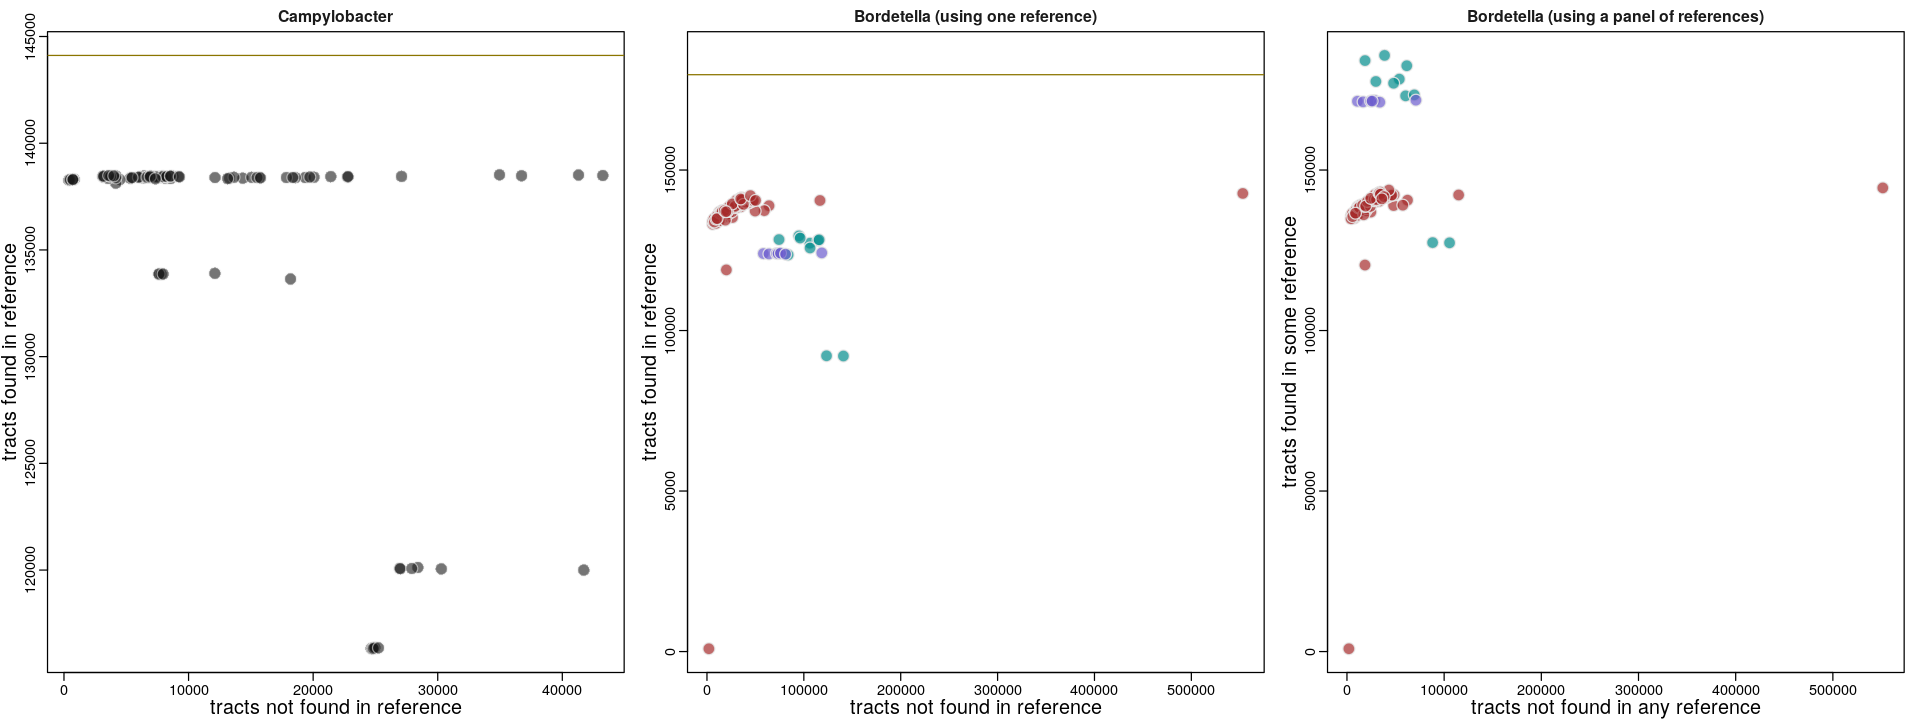

In [3]:
x <- read.table("borde_pertussis-tract_list.tsv.xz", header=T)
cat ("pertussis without tohama: ", length(x[,1]))
x <- read.table("borde_3refs-tract_list.tsv.xz", header=T)
cat ("   3refs  without tohama: ", length(x[,1]), "\n")

a1 <- read.table("campy-found_in_ref_withnames.txt") ## raw output from `grep "found and " nohup.out`
x1 <- read.table("campy-tract_list.tsv.xz", header=T)
x1 <- length(x1[,1])
a2 <- read.table("borde_pertussis_plus_tohama-found_in_ref_withnames.txt")
x2 <- read.table("borde_pertussis_plus_tohama-tract_list.tsv.xz", header=T)
x2 <- length(x2[,1])
a3 <- read.table("borde_3refs_plus_tohama-found_in_ref_withnames.txt")
x3 <- read.table("borde_3refs_plus_tohama-tract_list.tsv.xz", header=T)
x3 <- length(x3[,1])

cat("tracts found in campy: ", x1, "  in borde with one ref: ", x2, "  and in borde usgin 3 refs: ", x3, "(with Tohama)\n")
options(repr.plot.width=16, repr.plot.height=6)
options(scipen=4); # controls how easily it used scientific notation

par (font=2, cex=1.2, col.main="gray10", cex.axis=1.1, cex.lab=1.5,tcl=-0.5, mgp=c(1.8,0.6,0), mar=c(3,3,2,1));
layout(matrix(1:3,ncol=3,nrow=1, byrow=F));

plot(a1$V5, a1$V2, ylim=c(min(a1$V2),x1), xlab="tracts not found in reference", ylab="tracts found in reference", 
     pch=21, col=alpha("gray90",0.6), cex=2, bg=alpha("gray10",0.6),  main="Campylobacter") #  bg="gray80", col="firebrick"
abline (h=x1, col="gold4")

col_to_use2 <- return_borde_colours_to_use(a2$V1)
plot(a2$V5, a2$V2, ylim=c(min(a2$V2, a3$V2),max(a2$V2,a3$V2)), xlab="tracts not found in reference", ylab="tracts found in reference", 
     pch=21, col=alpha("gray90",0.9), cex=2, bg=alpha(col_to_use2,0.7), main="Bordetella (using one reference)") ## "cadetblue"
abline (h=x2, col="gold4")

col_to_use3 <- return_borde_colours_to_use(a3$V1)
plot(a3$V5, a3$V2, ylim=c(min(a2$V2, a3$V2),max(a2$V2,a3$V2)), xlab="tracts not found in any reference", ylab="tracts found in some reference", 
     pch=21, col=alpha("gray90",0.9), cex=2, bg=alpha(col_to_use3,0.7), main="Bordetella (using a panel of references)") ## "cadetblue"
abline (h=x3, col="gold4")


svg(filename="figures.not_found_in_ref.svg", width=14, height=5, pointsize=12)
options(scipen=4); # controls how easily it used scientific notation
par (font=2, cex=1.2, col.main="gray10", cex.axis=1.1, cex.lab=1.5,tcl=-0.5, mgp=c(1.8,0.6,0), mar=c(3,3,2,1));
layout(matrix(1:3,ncol=3,nrow=1, byrow=F));
plot(a1$V5, a1$V2, ylim=c(min(a1$V2),max(a1$V2)), xlab="tracts not found in reference", ylab="tracts found in reference", cex.main=2,
     pch=21, col=alpha("gray90",0.6), cex=2, bg=alpha("gray10",0.6),  main=expression(italic("Campylobacter jejuni"))) #  bg="gray80", col="firebrick"
#abline (h=x1, col="gold4")
plot(a2$V5, a2$V2, ylim=c(min(a2$V2, a3$V2),max(a2$V2,a3$V2)), cex.main=2,
     xlab="tracts not found in reference", ylab="tracts found in reference", 
     pch=21, col=alpha("gray90",0.9), cex=2, bg=alpha(col_to_use2,0.7), main=expression(italic("Bordetella spp.")~"using one reference")) ## "cadetblue"
#abline (h=x2, col="gold4")
plot(a3$V5, a3$V2, ylim=c(min(a2$V2, a3$V2),max(a2$V2,a3$V2)),cex.main=2,
     xlab="tracts not found in any reference", ylab="tracts found in one of references", 
     pch=21, col=alpha("gray90",0.9), cex=2, bg=alpha(col_to_use3,0.7), main=expression(italic("Bordetella spp.")~"using a panel of references")) ## "cadetblue"
#abline (h=x3, col="gold4")
dev.off()

In [4]:
x <- read.table("campy-per_sample_average_length.tsv.xz", sep="\t", header=T)
x1 <- length(x$feature); x2 <- sum(x$feature=="unannotated")
cat ("EXCLUDES tohama\n\ncampy \t\t interesting: ", x1, "\t annotated: ", x1-x2, "\t unannotated: ", x2, "\n")

x <- read.table("borde_pertussis-per_sample_average_length.tsv.xz",  sep="\t", header=T)
x1 <- length(x$feature); x2 <- sum(x$feature=="unannotated")
cat ("pertussis \t interesting: ", x1, "\t annotated: ", x1-x2, "\t unannotated: ", x2, "\n")

x <- read.table("borde_3refs-per_sample_average_length.tsv.xz",  sep="\t", header=T)
x1 <- length(x$feature); x2 <- sum(x$feature=="unannotated")
cat ("3refs \t\t interesting: ", x1, "\t annotated: ", x1-x2, "\t unannotated: ", x2, "\n")

EXCLUDES tohama

campy 		 interesting:  41103 	 annotated:  36603 	 unannotated:  4500 
pertussis 	 interesting:  123686 	 annotated:  106206 	 unannotated:  17480 
3refs 		 interesting:  495121 	 annotated:  436908 	 unannotated:  58213 


## dendrograms, using Tatajuba and snippy

### first, *Campylobacter*

[1] 104

[1] 101

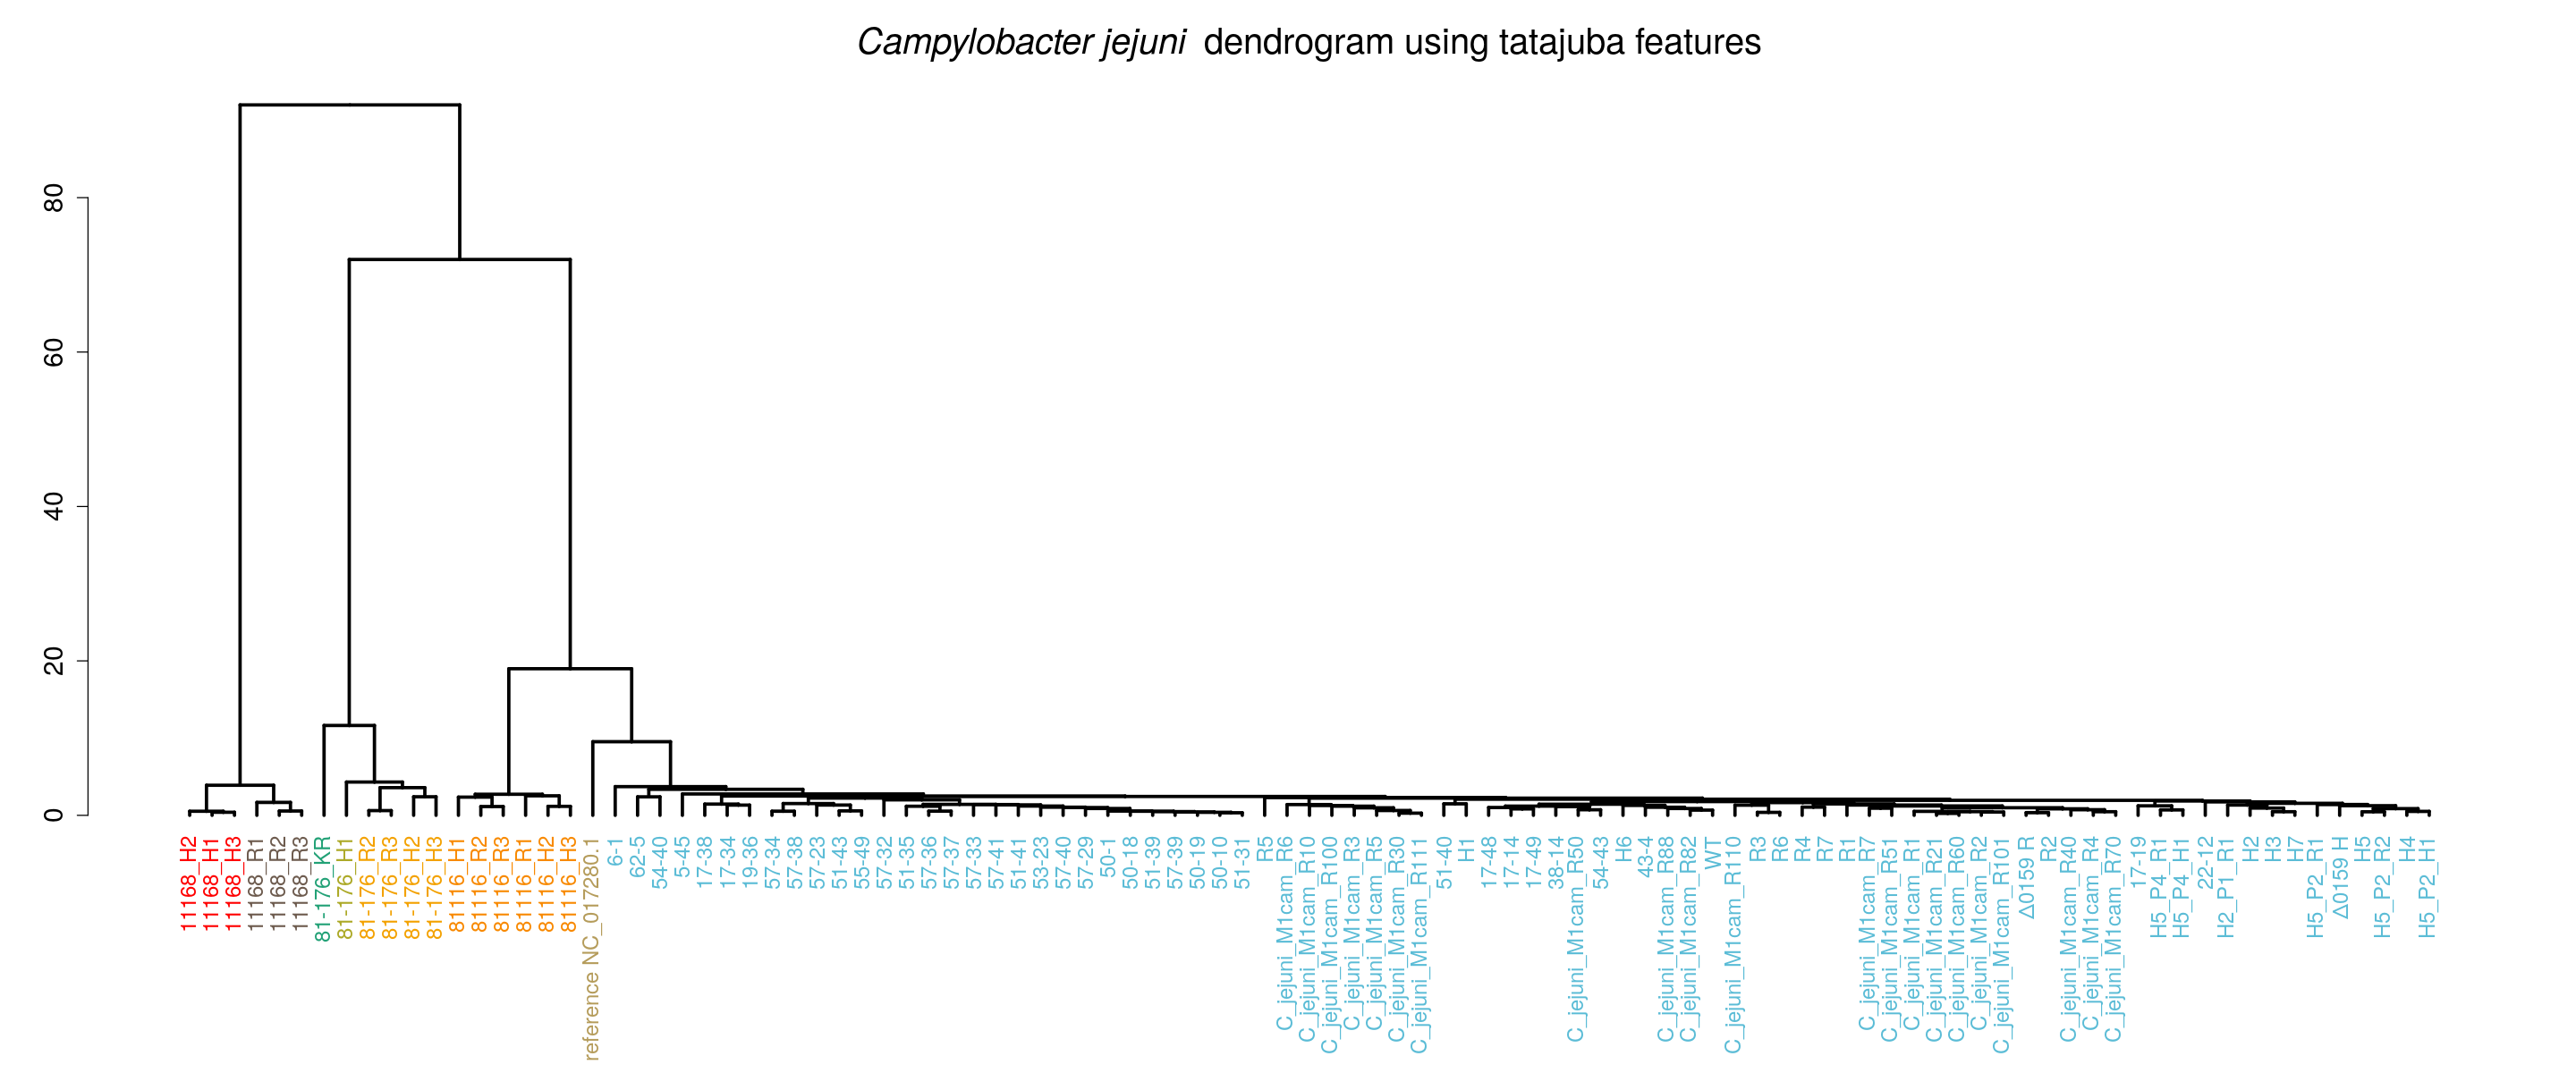

In [5]:
 # check.names replaces backslash by "."
a<-read.table("campy-per_sample_average_length.tsv.xz", sep="\t", header=T, check.names = F)
x<-t(as.matrix(a[,4:length(a)]))
length(a)
rownames(x)<-gsub ("_1.fastq.gz","",rownames(x))
rownames(x)<-gsub (".*/","",rownames(x))

rownames(x) <- campy_names[rownames(x)] 
length(rownames(x))
calen <- x
colnames(calen) <- a$location

options(repr.plot.width=24, repr.plot.height=10) ; par(oma=c(0,0,0,0),cex.axis = 1.5)
#tat_dist_campy <- dist(round(x,0))
tat_dist_campy <- dist(x)
cls_campy <- hclust(tat_dist_campy, method="average") 

cls_campy <- color_labels (as.dendrogram (cls_campy), k=8, col=colorRampPalette(wes_palette("Darjeeling1"))(8))
cls_campy <- cls_campy %>%  set("branches_lwd", 3)  %>% set("labels_cex", 1.2) %>% 
    hang.dendrogram(hang_height = 1, hang=-0.1)
## tanglegram complains about labels not matching but labels(cls_campy_snp) %in% labels(cls_campy) is TRUE
cls_campy <- set(cls_campy, what = c( "labels_to_character"), )

campy_cluster_colors <- labels_colors(cls_campy)

plot (cls_campy, main=expression(italic("Campylobacter jejuni")~"dendrogram using tatajuba features"), cex=1.4, cex.main=2, xlab="",sub="", ylim=c(-15,90))

#### check if fractionary average HT lengths (i.e. including non-modal lengths) affect the result
that is, simulate an equivalent "consensus" HT vector (the answer is "no", there is no change)

In [6]:
x2 <- round(x,0)
sqrt(sum((x - x2)^2,na.rm=TRUE))
sum(abs(x - x2),na.rm=TRUE)/sum(x,na.rm=T)
sum(x2,na.rm=T)/sum(x,na.rm=T)

[1] 6.608669

[1] 0.00002055989

[1] 1.000003

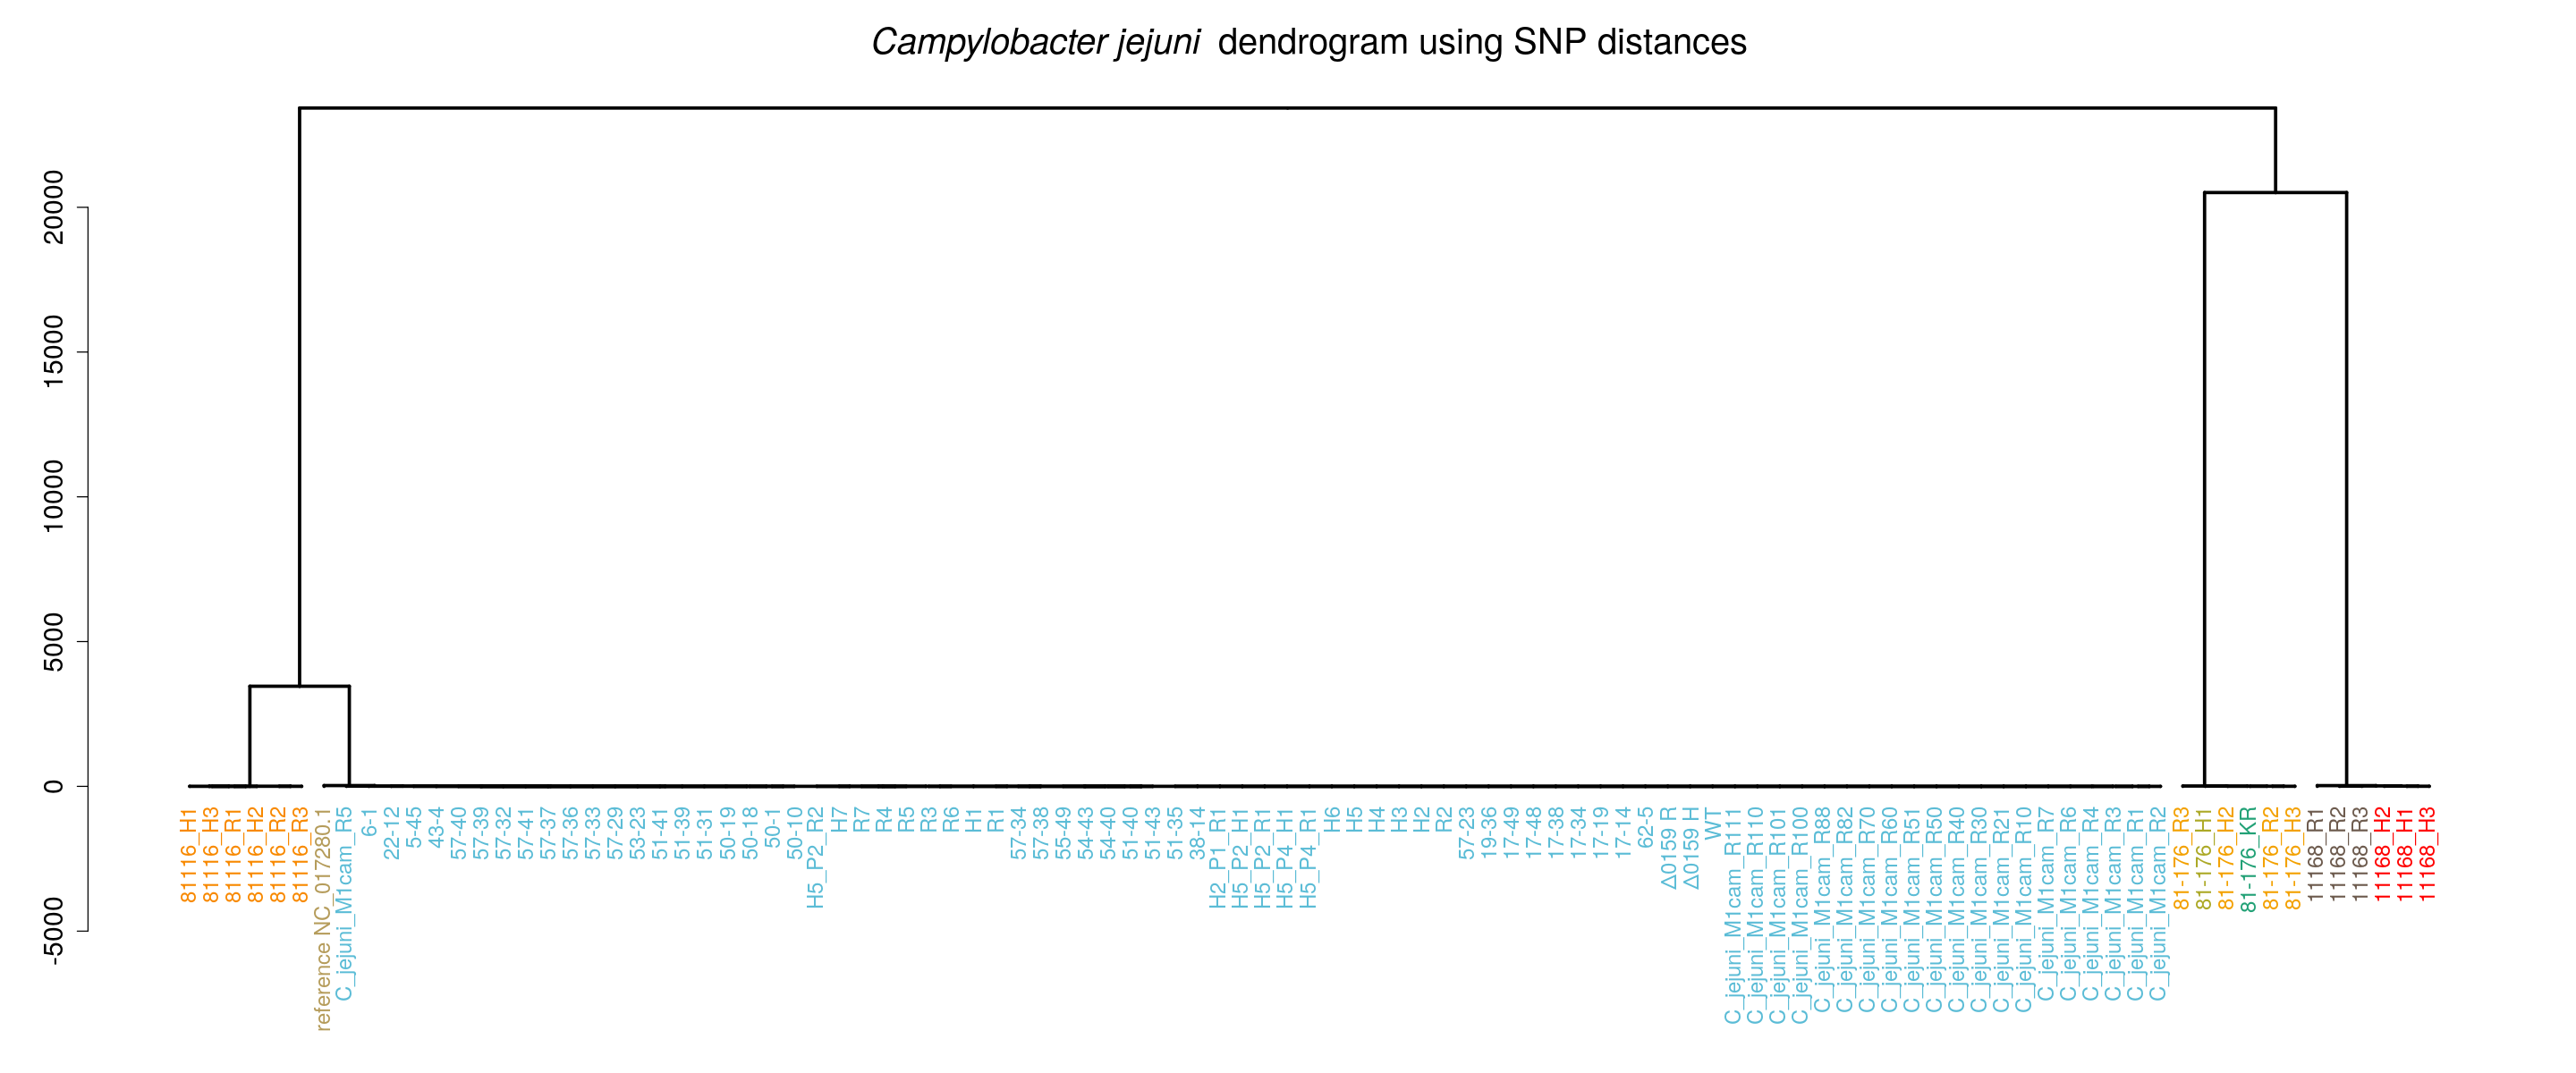

In [7]:
x <- data.matrix(read.table("campy-snippycore.dist", fill=T, row.names=1, skip=1))
rownames(x)<-gsub ("out","",rownames(x)) ## snippy created new folder "outERRxxx" to avoid overwriting original ones
rownames(x) <- campy_names[rownames(x)] 
colnames(x) <- rownames(x)
snp_dist_campy <- as.dist(x)

cls_campy_snp <- hclust(snp_dist_campy, method="average")
cls_campy_snp <- as.dendrogram (cls_campy_snp) %>% 
    hang.dendrogram(hang=-0.1, hang_height = 0.01) %>% set("branches_lwd", 3)  %>% set("labels_cex", 1.2)
## tanglegram complains about labels not matching but labels(cls_campy_snp) %in% labels(cls_campy) is TRUE  
cls_campy_snp <- set(cls_campy_snp, what = c( "labels_to_character"), )
labels_colors(cls_campy_snp) <- campy_cluster_colors[rownames(x)[order.dendrogram(cls_campy_snp)]]

options(repr.plot.width=24, repr.plot.height=10) ; par(oma=c(0,0,0,0),cex.axis = 1.5)
plot (cls_campy_snp, main=expression(italic("Campylobacter jejuni")~"dendrogram using SNP distances"), 
      cex=1.4, cex.main=2, xlab="",sub="", ylim=c(-5000,23000))


png 
  2

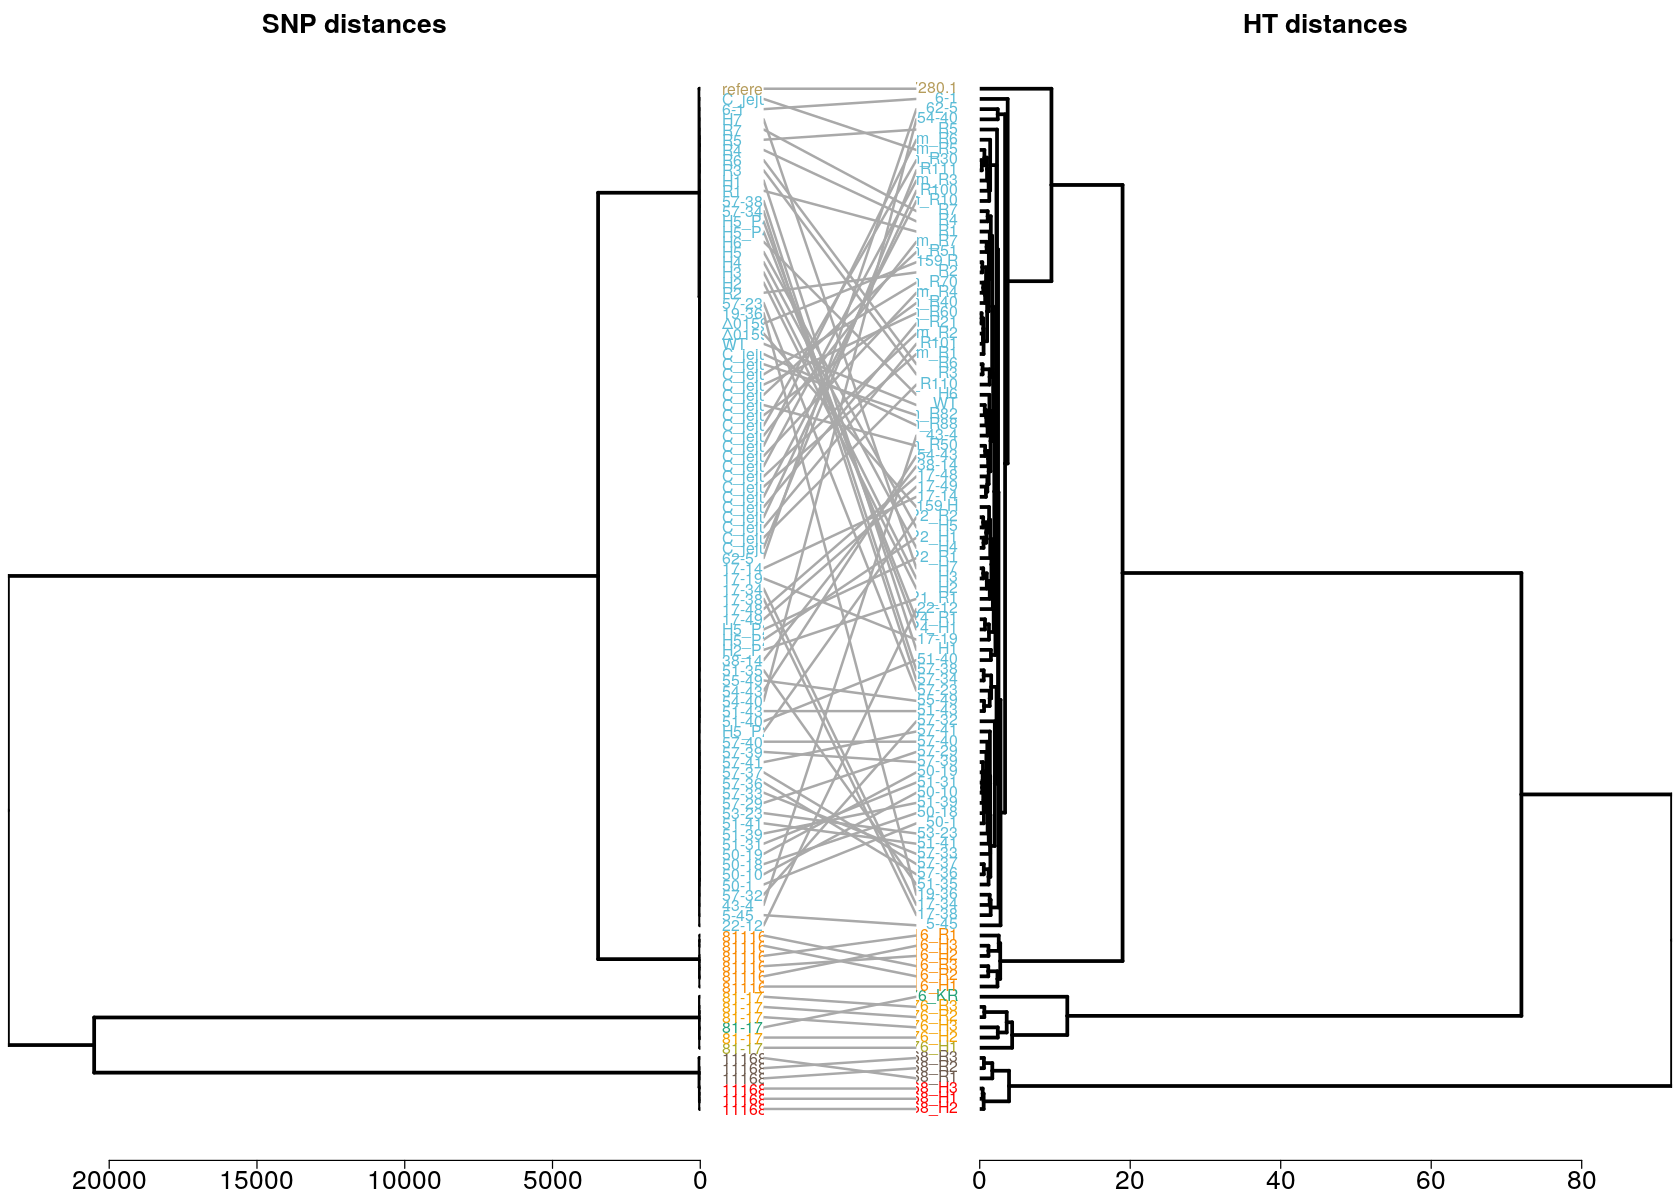

In [8]:
options(repr.plot.width=14, repr.plot.height=10) ; par(oma=c(0,0,0,0), cex.axis = 2)
tanglegram (dendlist(cls_campy_snp,cls_campy), sort=T, common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, highlight_branches_lwd = FALSE,
           main_left="SNP distances",main_right="HT distances",  margin_inner=4, columns_width = c(5, 1, 5), lwd=2)

svg(filename="figures.tanglegram_campy.svg", width=12, height=16, pointsize=12)
options(repr.plot.width=14, repr.plot.height=10) ; par(oma=c(0,0,0,0), cex.axis = 2)
tanglegram (dendlist(cls_campy_snp,cls_campy), sort=T, common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, highlight_branches_lwd = FALSE,
           main_left="SNP distances",main_right="HT distances",  margin_inner=10, columns_width = c(6, 1.5, 6), lwd=2, just_one=TRUE)
dev.off()

### And then *Bordetella* (excluding tohama)

* We plot dendrogram for both single-reference (pertussis) and for 3-species panel
* However snippy comparison is with single-reference only

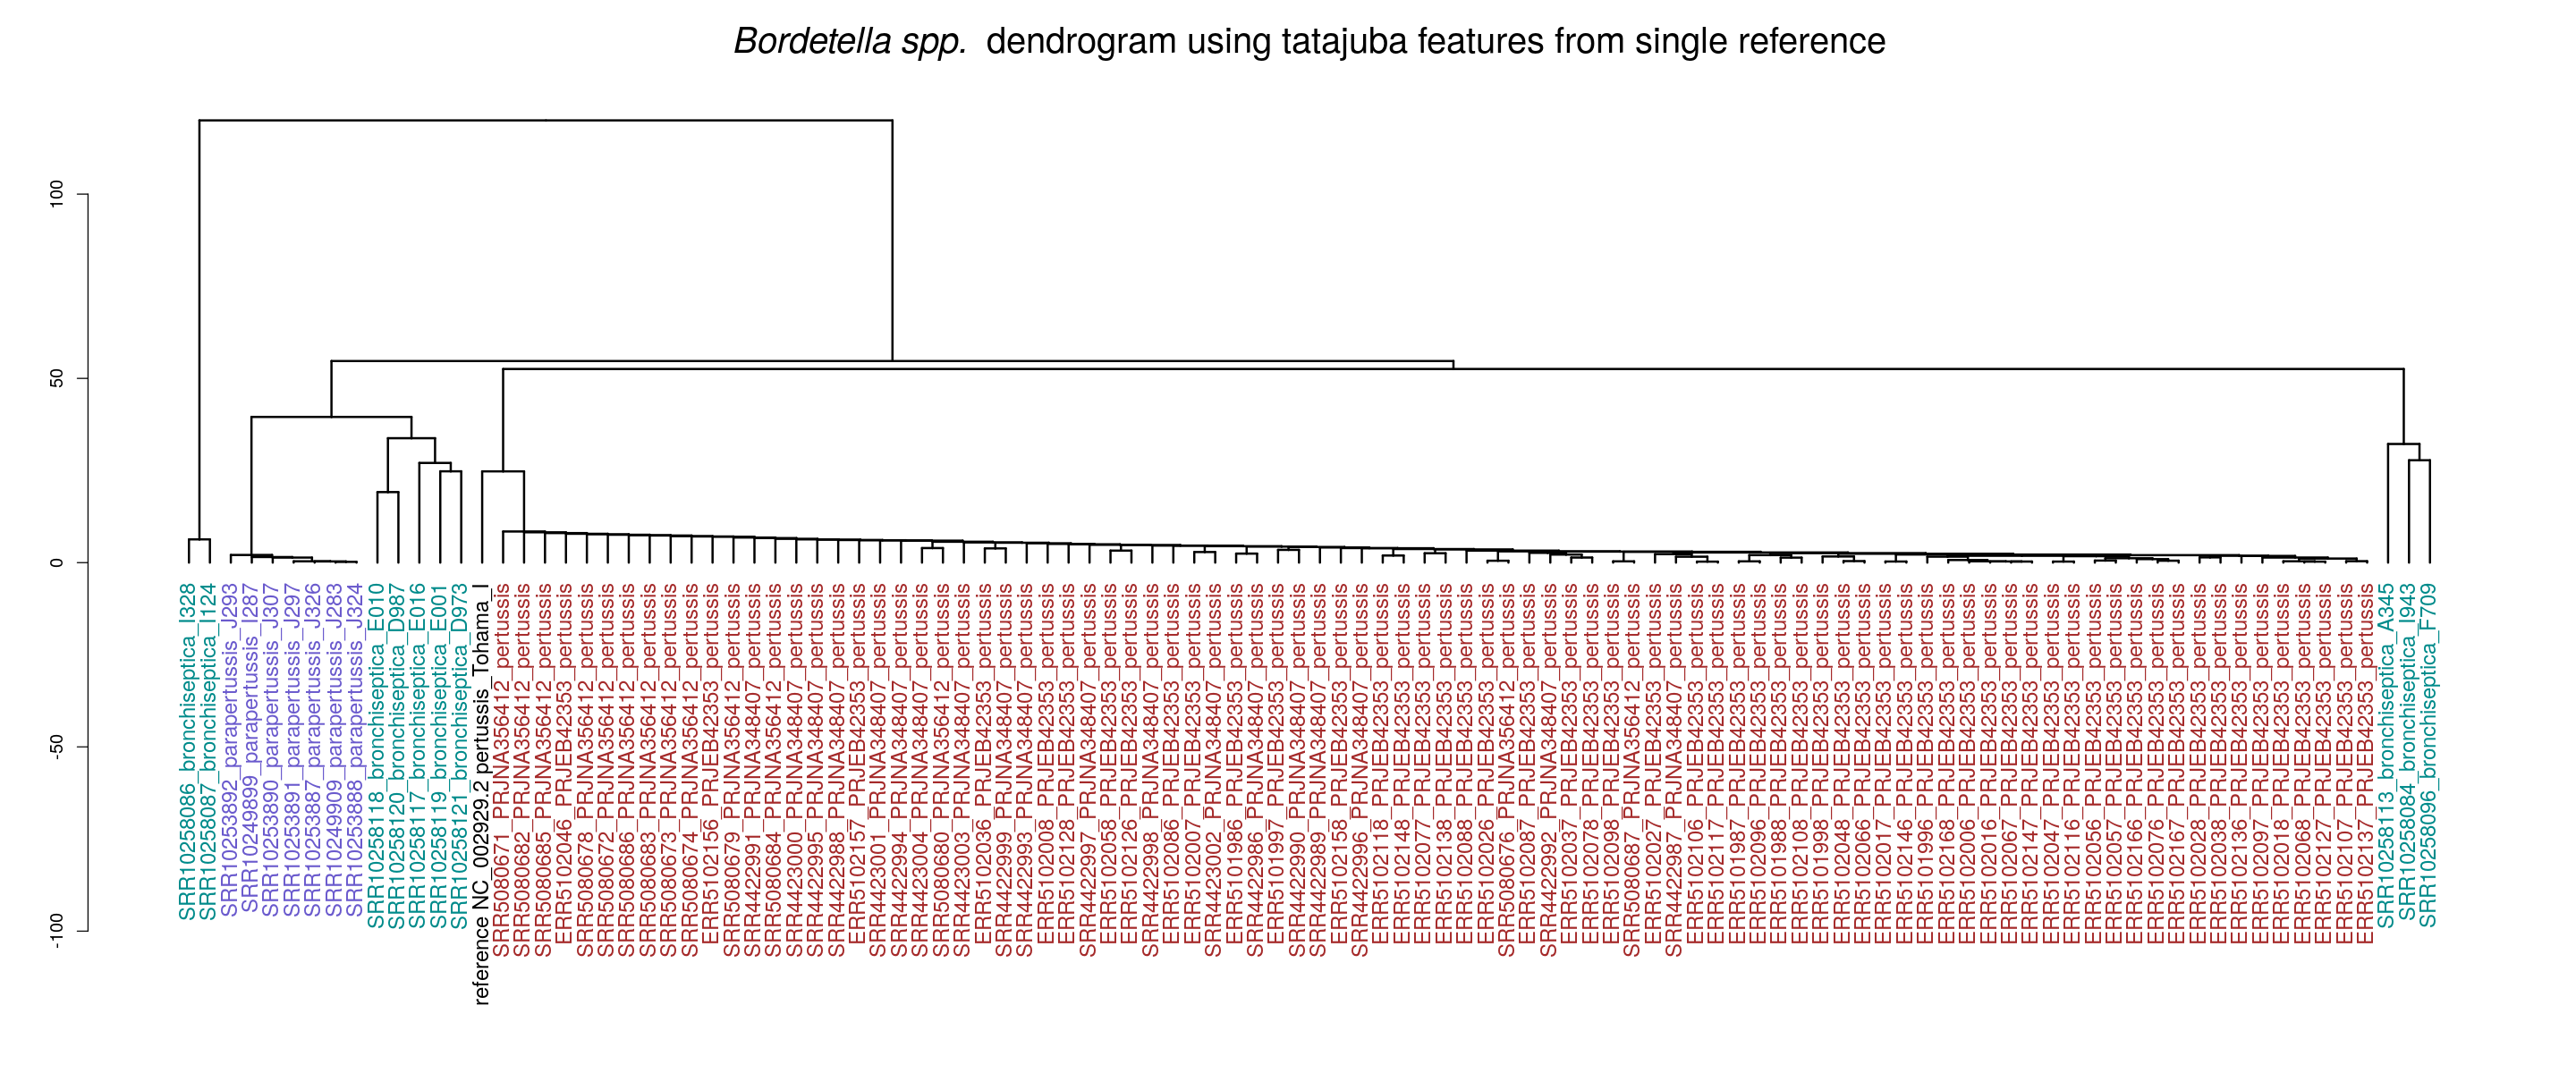

In [9]:
 # check.names replaces backslash by "."
a<-read.table("borde_pertussis-per_sample_average_length.tsv.xz", sep="\t", header=T, check.names = F)
x<-t(as.matrix(a[,4:length(a)]))
rownames(x)<-replace_borde_names(rownames(x))

tat_dist_borde <- dist(x)  ## THIS will be used when scatter plotting
clst <- as.dendrogram(hclust(tat_dist_borde, method="average"))
## write.csv (rownames(x), "bordetella.names") ## gawk -F '"' '{print $4}' bordetella.names | sort > 004.bordetella/accession_files/bordetella_samples.csv
options(repr.plot.width=24, repr.plot.height=10) ; par(oma=c(0,0,0,0))
dend <- clst

col_to_use <- return_borde_colours_to_use(rownames(x))
#labels_colors(dend) <- colorspace::rainbow_hcl(4, c = 50, l  = 20)[ col_to_use[order.dendrogram(dend)]] ## reorder based on dendrogram
labels_colors(dend) <- col_to_use[order.dendrogram(dend)]
borde_cluster_colors <- labels_colors(dend)

dend <- dend %>% hang.dendrogram(hang_height = 0.01, hang=-0.1) %>% set("branches_lwd", 2)  %>% set("labels_cex", 1.2)
cls_borde_pertussis <- set(dend, what = c( "labels_to_character"), )

plot (cls_borde_pertussis, main=expression(italic("Bordetella spp.")~"dendrogram using tatajuba features from single reference"), 
      cex=1.2, cex.main=2, xlab="",sub="", ylim=c(-100, 120))

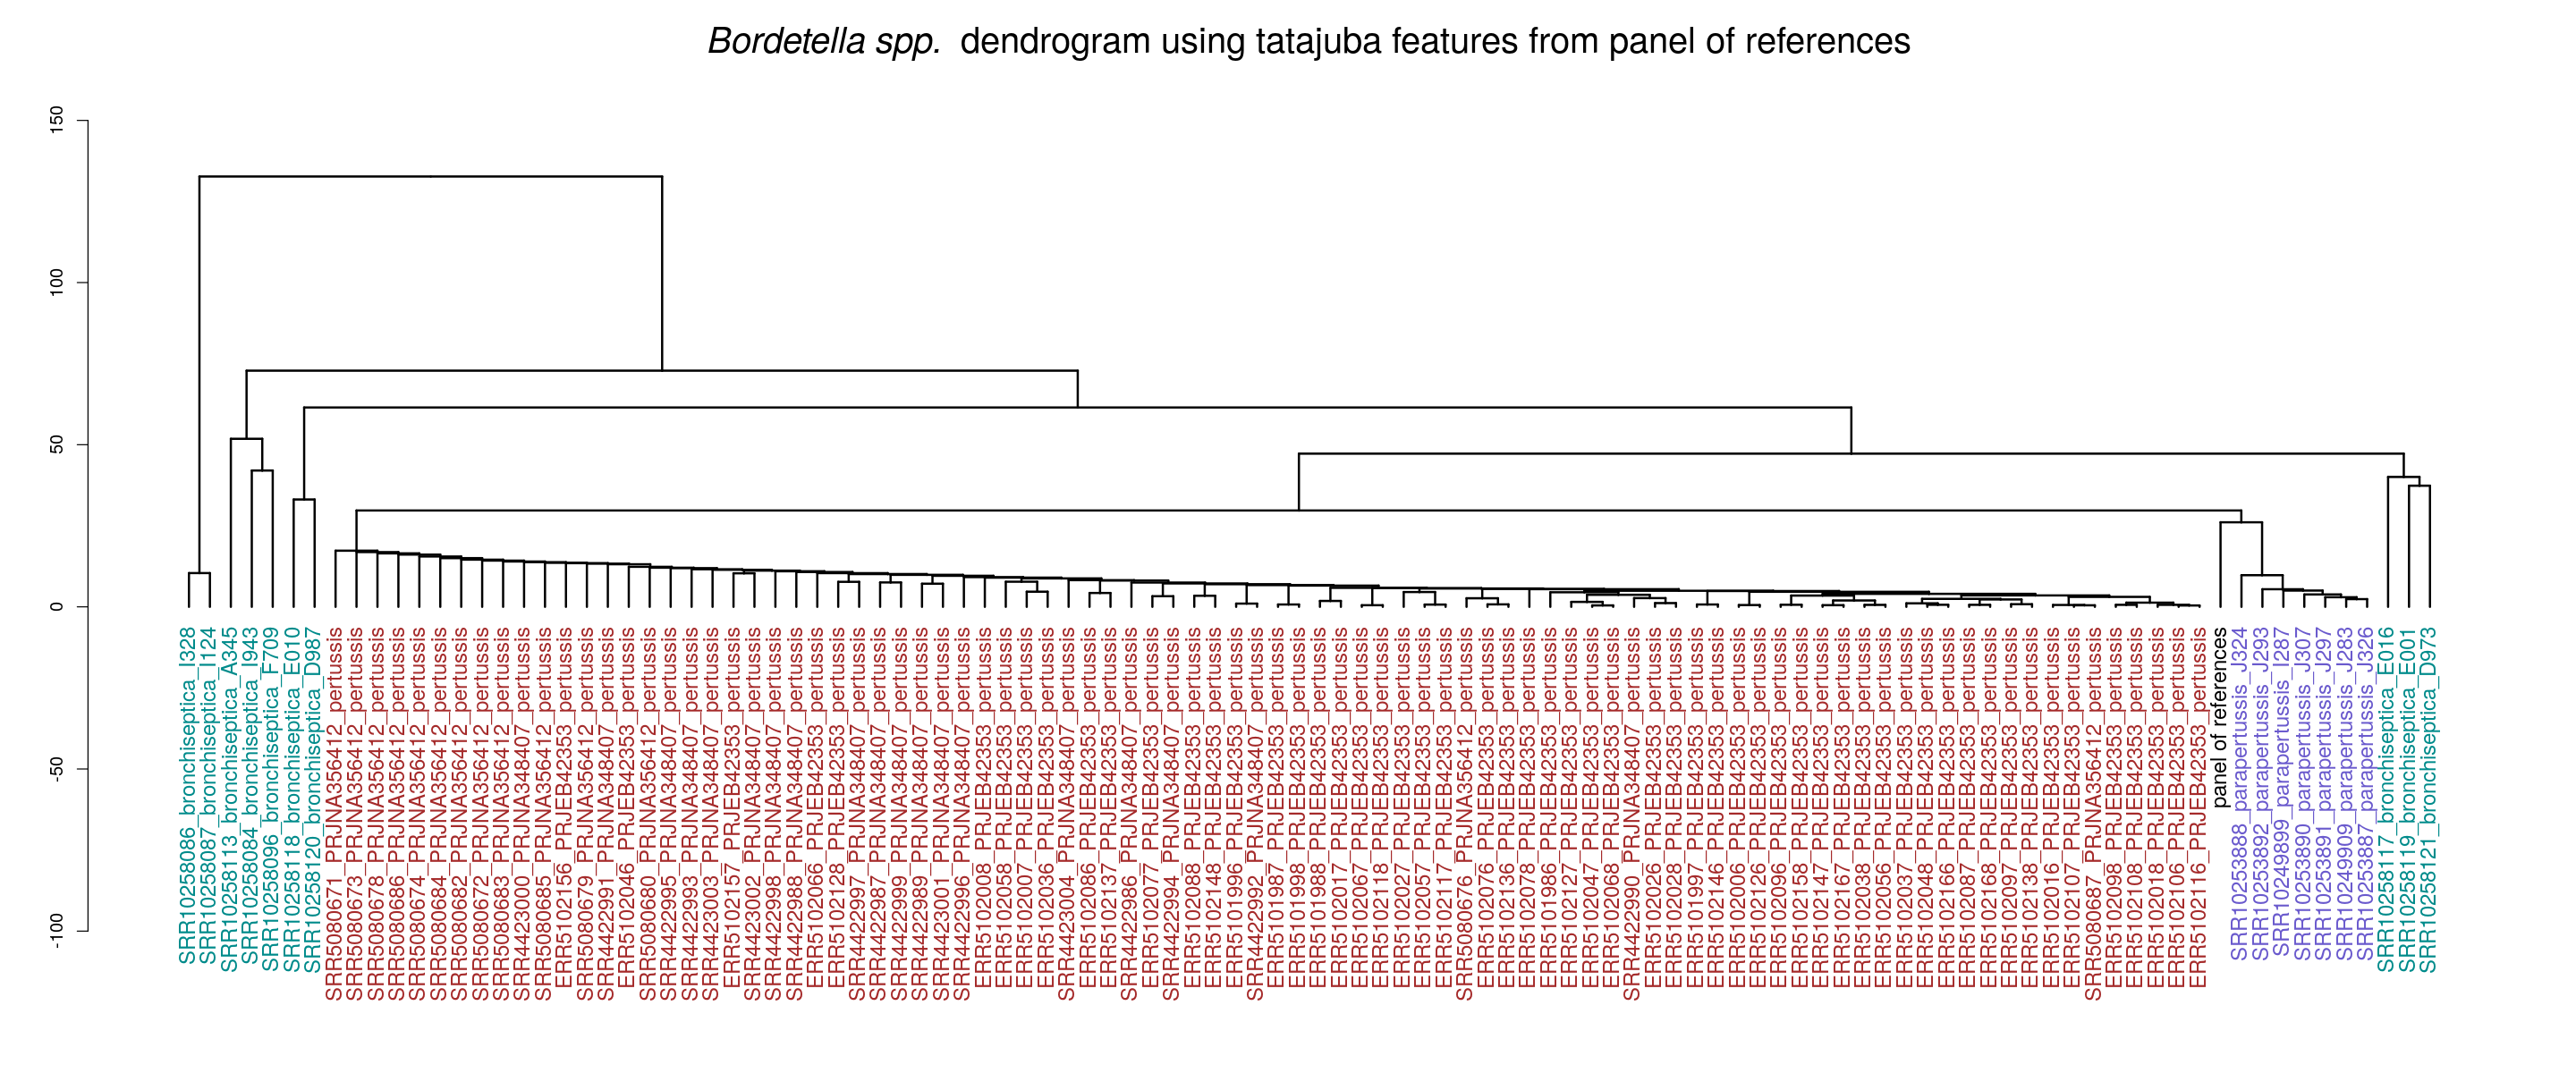

In [10]:
a<-read.table("borde_3refs-per_sample_average_length.tsv.xz", sep="\t", header=T, check.names = F) # check.names replaces backslash by "."
x<-t(as.matrix(a[,4:length(a)]))
rownames(x)<-replace_borde_names(rownames(x))
rownames(x)<-gsub ("reference NC_002929.2 pertussis_Tohama_I","panel of references", rownames(x))

tat_dist_borde_3refs <- dist(x)
clst <- as.dendrogram(hclust(tat_dist_borde_3refs, method="average"))
## write.csv (rownames(x), "bordetella.names") ## gawk -F '"' '{print $4}' bordetella.names | sort > 004.bordetella/accession_files/bordetella_samples.csv
options(repr.plot.width=24, repr.plot.height=10) ; par(oma=c(0,0,0,0))
dend <- clst

col_to_use <- return_borde_colours_to_use(rownames(x))
#labels_colors(dend) <- colorspace::rainbow_hcl(4, c = 50, l  = 20)[ col_to_use[order.dendrogram(dend)]] ## reorder based on dendrogram
labels_colors(dend) <- col_to_use[order.dendrogram(dend)]
borde_cluster_colors <- labels_colors(dend)

dend <- dend %>% hang.dendrogram(hang_height = 0.01, hang=-0.1) %>% set("branches_lwd", 2)  %>% set("labels_cex", 1.2)
cls_borde_3refs <- set(dend, what = c( "labels_to_character"), )

plot (cls_borde_3refs, main=expression(italic("Bordetella spp.")~"dendrogram using tatajuba features from panel of references"), 
      cex=1.2, cex.main=2, xlab="",sub="", ylim=c(-100, 150))

#### save 3 dendrograms in SVG format

In [11]:
svg(filename="figures.both_upgma.svg", width=18, height=20, pointsize=12)
layout( matrix(c(1,2,3), ncol=1))
par(cex.axis = 1.5)
cls_campy <- cls_campy %>%  sort(type = "nodes") 
cls_borde_pertussis <- cls_borde_pertussis %>%  sort(type = "nodes") 
cls_borde_3refs <- cls_borde_3refs %>%  sort(type = "nodes") 
plot (cls_campy, main=expression(italic("Campylobacter jejuni")), cex.lab=1.1, cex=1.2, cex.main=4, xlab="",sub="",  ylim=c(-15,90))
plot (cls_borde_pertussis, main=expression(italic("Bordetella spp.")~"dendrogram using one reference"),  
      cex.lab=1.1, cex=1.2, cex.main=4, xlab="",sub="", ylim=c(-100, 120))
plot (cls_borde_3refs, main=expression(italic("Bordetella spp.")~"dendrogram using a panel of references"),
      cex.lab=1.1, cex=1.2, cex.main=4, xlab="",sub="", ylim=c(-100, 145))
dev.off()

png 
  2

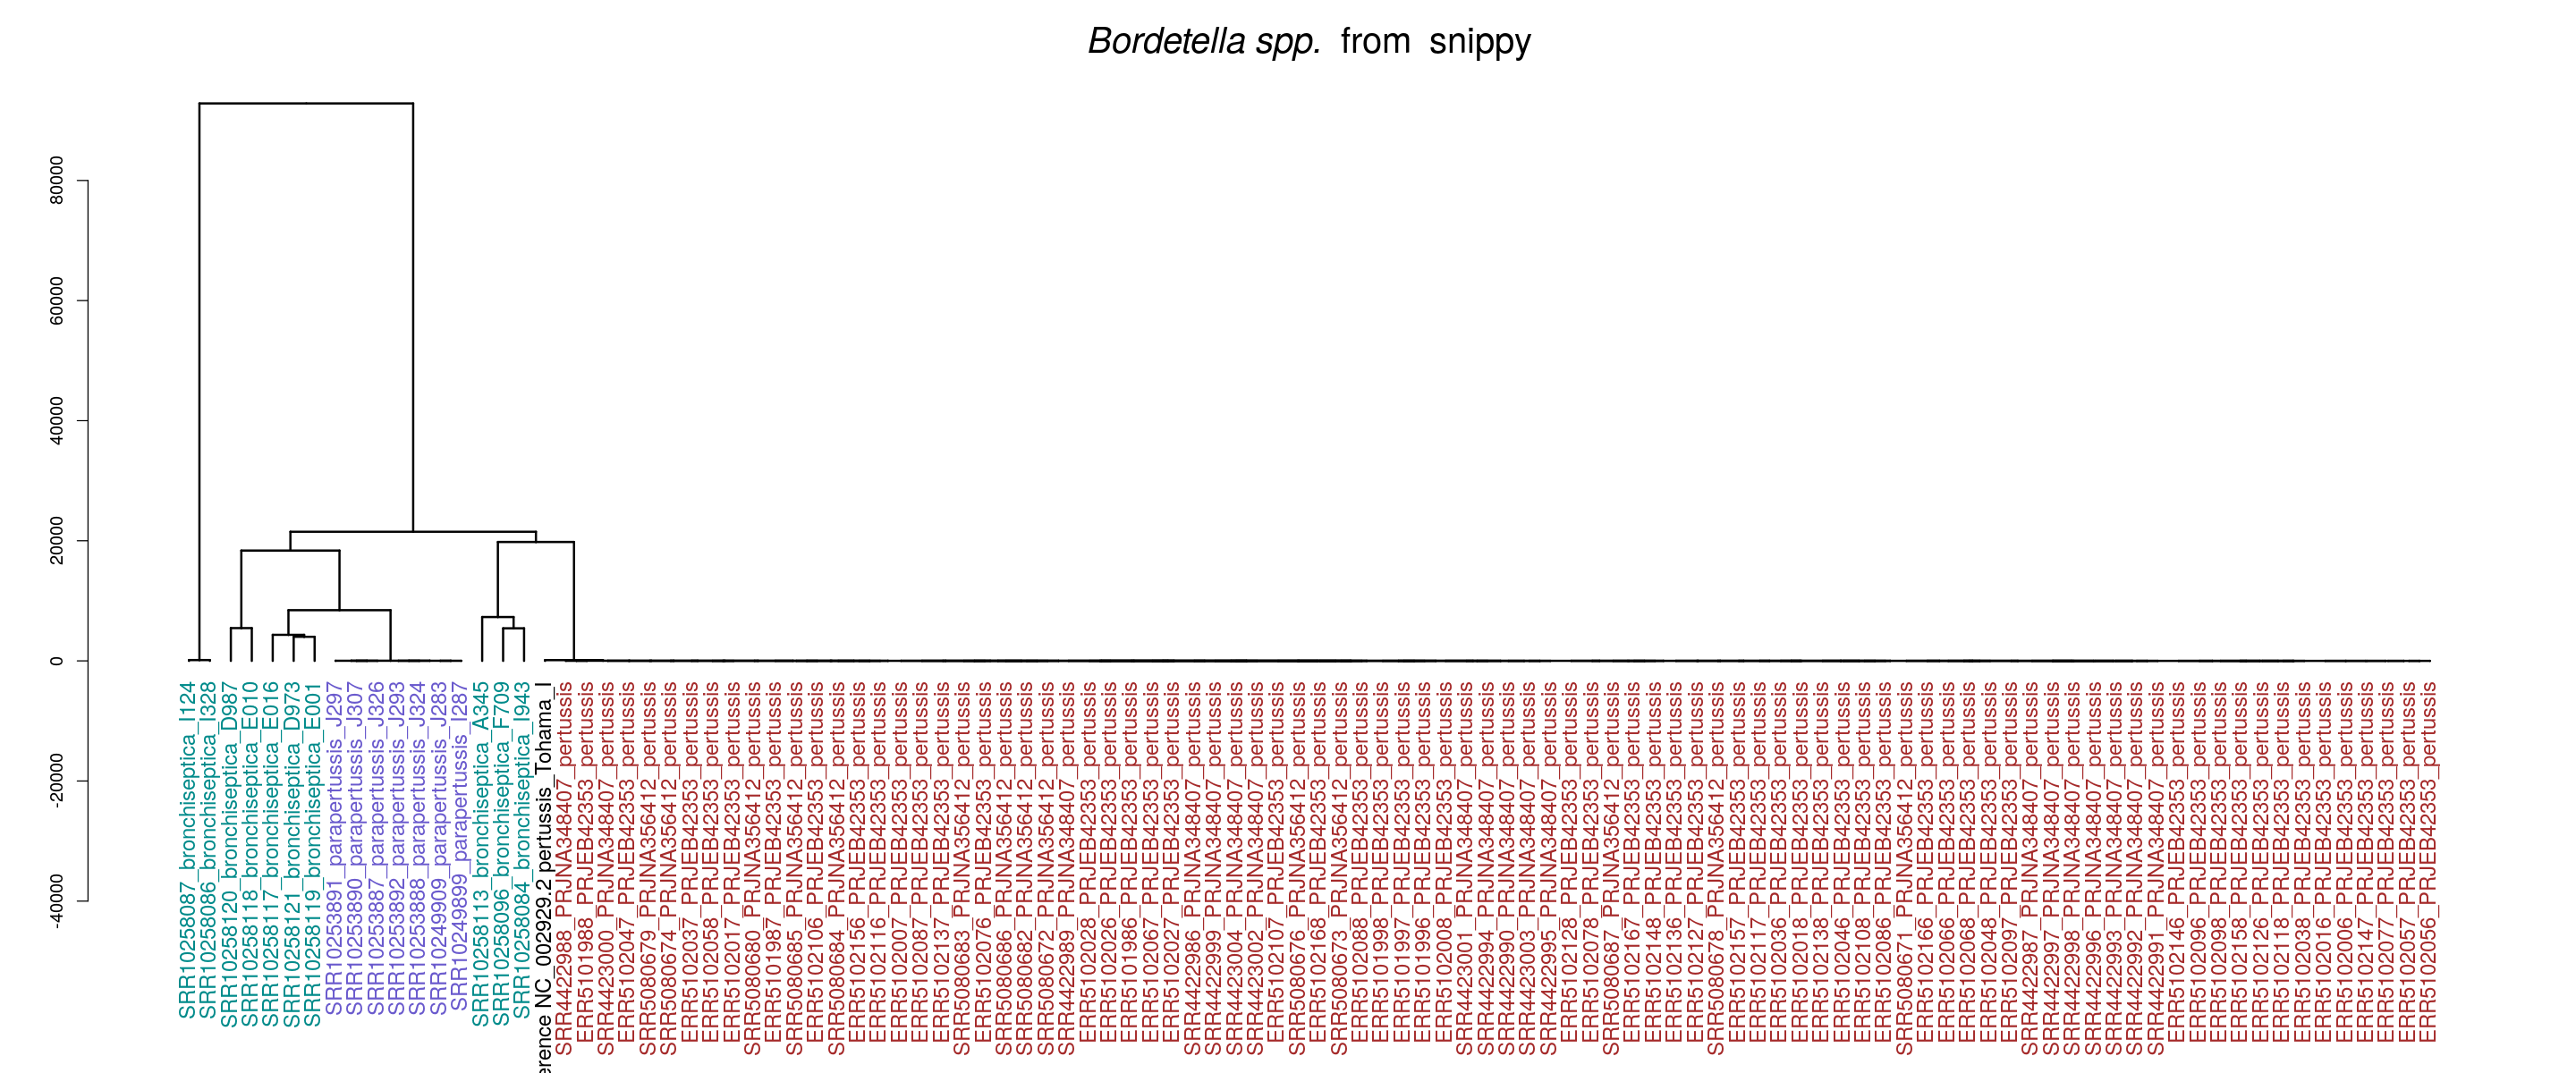

In [12]:
x <- data.matrix(read.table("borde-snippycore.dist", fill=T, row.names=1, skip=1))
rownames(x)<-replace_borde_names(rownames(x))
colnames(x) <- rownames(x)
x <- x[!rownames(x) %in% "ERR4176311_PRJEB38438_pertussis", !colnames(x) %in% "ERR4176311_PRJEB38438_pertussis"] ## exclude biased sample
snp_dist_borde <- as.dist(x)

cls_borde_snp <- hclust(snp_dist_borde, method="average")
cls_borde_snp <- as.dendrogram (cls_borde_snp) %>% hang.dendrogram(hang=-0.1,hang_height = 0.01) %>% set("branches_lwd", 2)  %>% set("labels_cex", 1.2)
## tanglegram complains about labels not matching but labels(cls_campy_snp) %in% labels(cls_campy) is TRUE
cls_borde_snp <- set(cls_borde_snp, what = c( "labels_to_character"), )

col_to_use <- return_borde_colours_to_use(rownames(x))
#labels_colors(dend) <- colorspace::rainbow_hcl(4, c = 50, l  = 20)[ col_to_use[order.dendrogram(dend)]] ## reorder based on dendrogram
labels_colors(cls_borde_snp) <- col_to_use[order.dendrogram(cls_borde_snp)]
#labels_colors(cls_borde_snp) <- borde_cluster_colors[rownames(x)[order.dendrogram(cls_borde_snp)]]

cls_borde_snp <- cls_borde_snp %>%  sort(type = "nodes")
options(repr.plot.width=24, repr.plot.height=10) ; par(oma=c(0,0,0,0))
plot (cls_borde_snp, main=expression(italic("Bordetella spp.")~from~snippy), cex=1., cex.main=2, xlab="",sub="",ylim=c(-45000,90000))

png 
  2

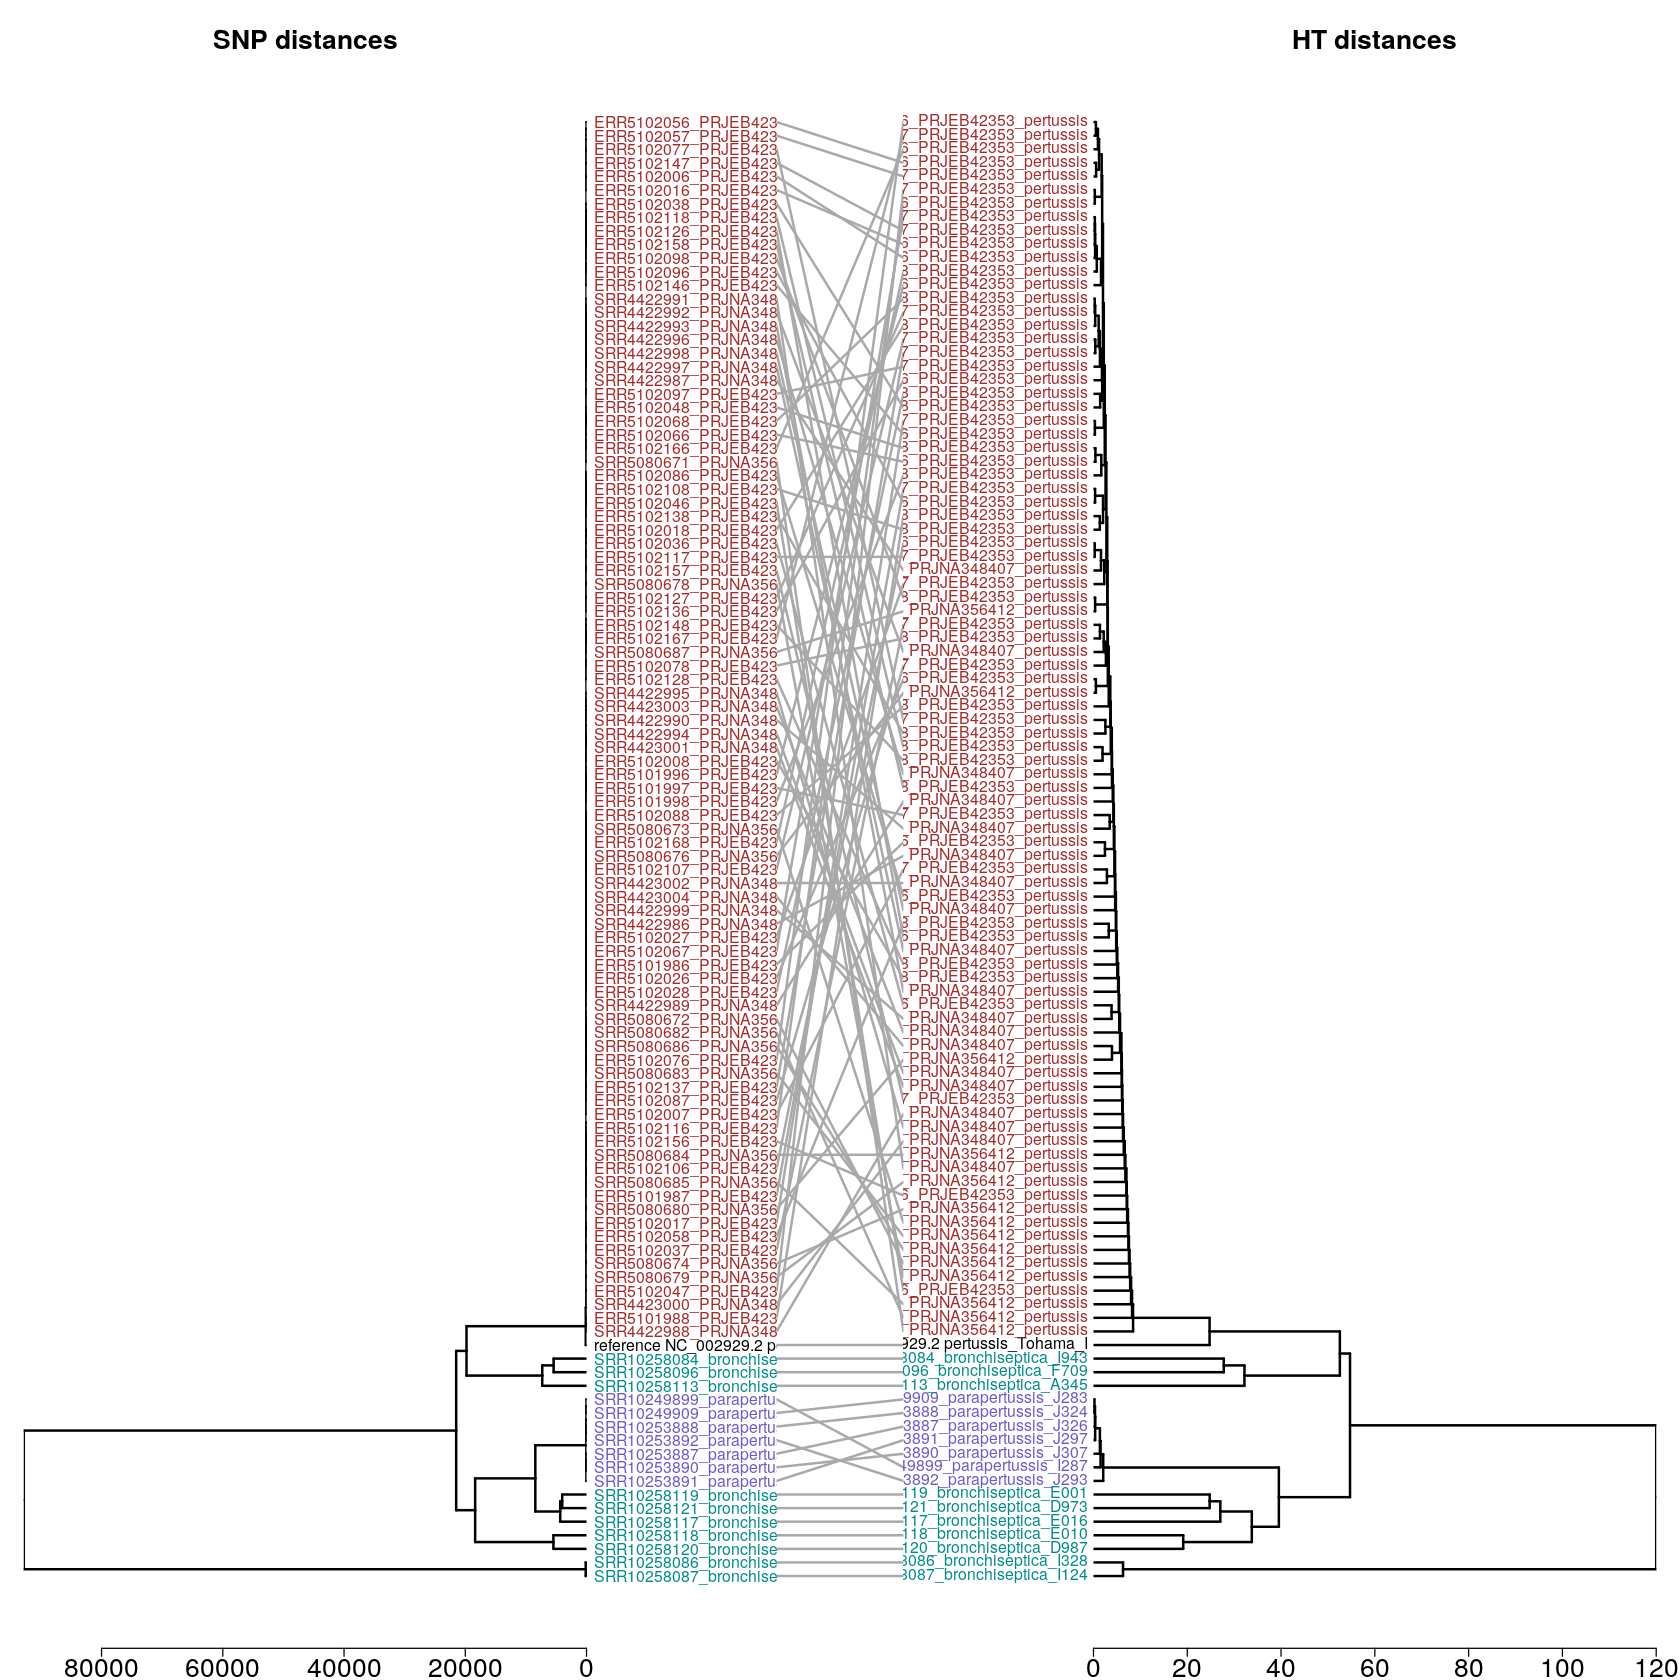

In [13]:
options(repr.plot.width=14, repr.plot.height=14) ; par(oma=c(1,1,1,1), cex.axis = 2)
tanglegram (dendlist(cls_borde_snp,cls_borde_pertussis), sort=F, common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, 
            highlight_branches_lwd = FALSE, dLeaf_left = -1000, dLeaf_right = 1, margin_bottom = 1,
            main_left="SNP distances",main_right="HT distances", margin_inner=12, columns_width = c(6, 1, 6), lwd=2)

svg(filename="figures.tanglegram_borde.svg", width=14, height=14, pointsize=12); par(oma=c(1,1,1,1), cex.axis = 2)
tanglegram (dendlist(cls_borde_snp,cls_borde_pertussis), sort=F, common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, 
            highlight_branches_lwd = FALSE,  dLeaf_left = -1000, dLeaf_right = 1, 
            main_left="SNP distances",main_right="HT distances", margin_inner=12, columns_width = c(6, 1, 6), lwd=2, just_one=TRUE)
dev.off()

png 
  2

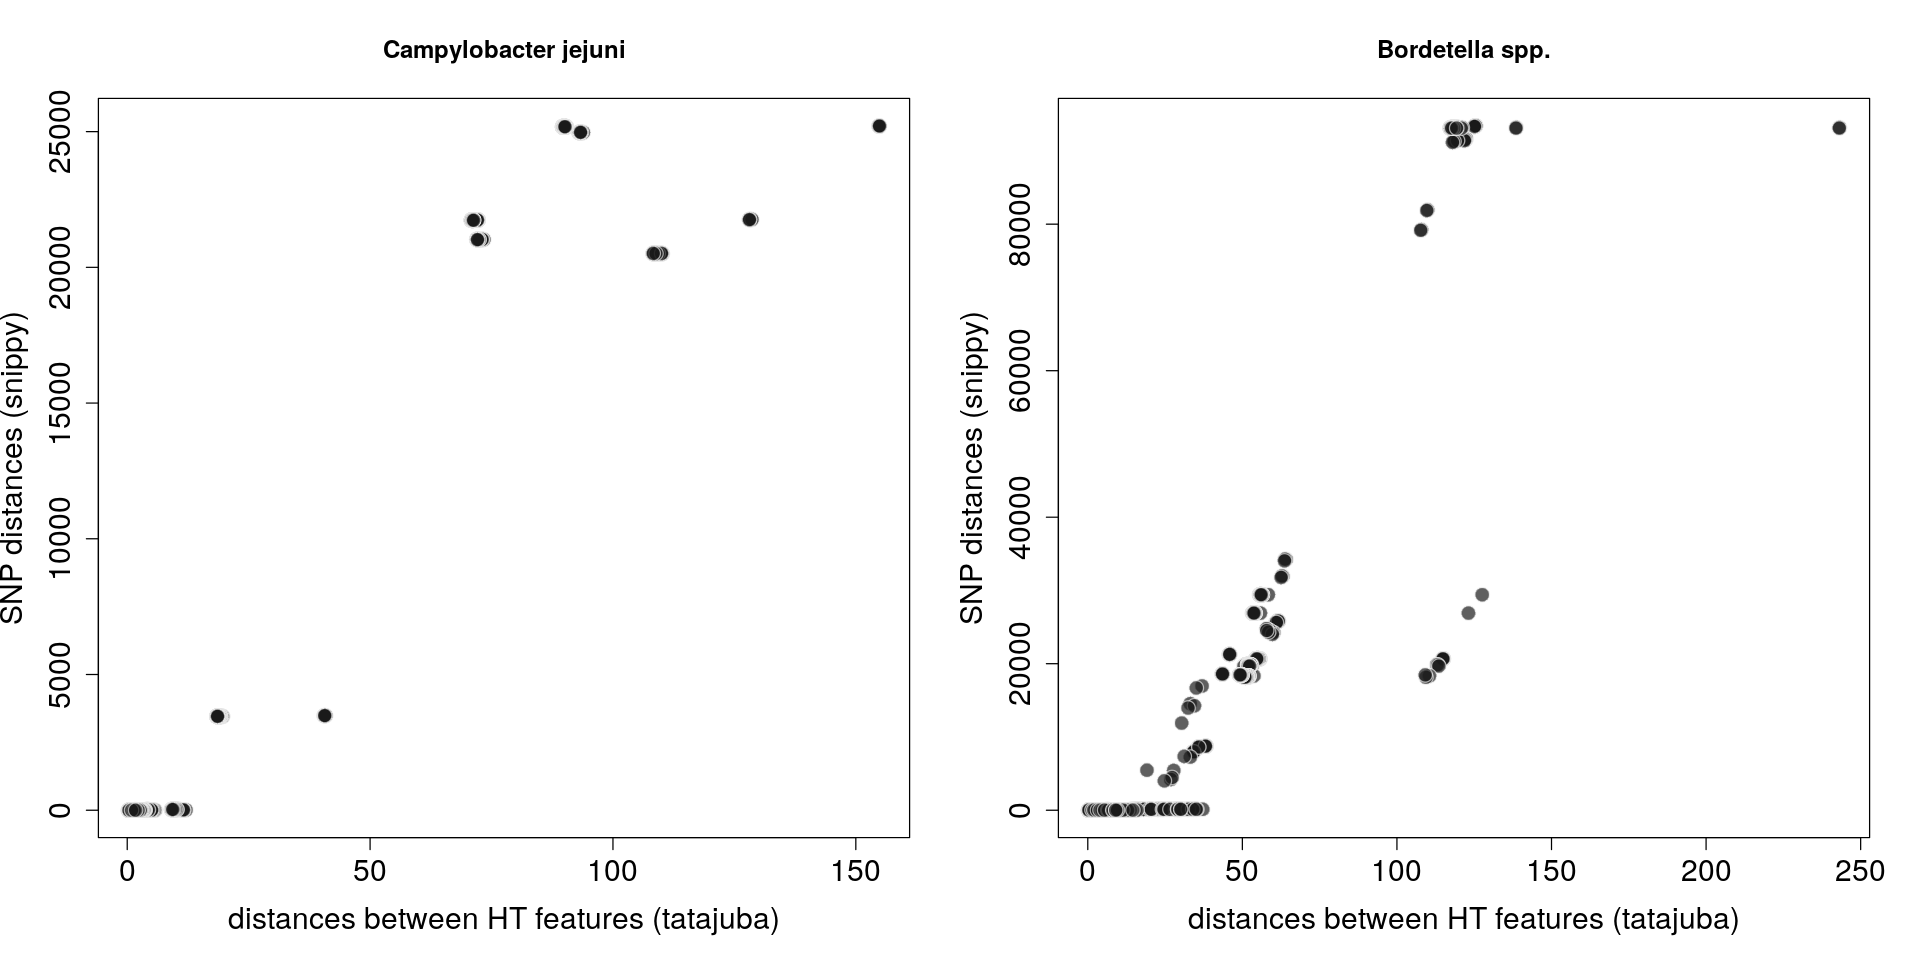

In [14]:
tat_dist_campy <- sort_dist_mat (tat_dist_campy)
snp_dist_campy <- sort_dist_mat (snp_dist_campy)
tat_dist_borde <- sort_dist_mat (tat_dist_borde)
snp_dist_borde <- sort_dist_mat (snp_dist_borde)

options(repr.plot.width=16, repr.plot.height=8) ; par(oma=c(0,0,0,0), cex.axis = 1.5, cex.lab = 1.5)
layout(matrix(c(1,2),ncol=2))
matplot(tat_dist_campy,snp_dist_campy, pch=21, col=alpha("gray90",0.7), cex=1.6, bg=alpha("gray10",0.7), 
       xlab="distances between HT features (tatajuba)", ylab="SNP distances (snippy)", main="Campylobacter jejuni")
matplot(tat_dist_borde,snp_dist_borde, pch=21, col=alpha("gray90",0.7), cex=1.6, bg=alpha("gray10",0.7), 
       xlab="distances between HT features (tatajuba)", ylab="SNP distances (snippy)", main="Bordetella spp.")


svg(filename="figures.snp_dist.svg", width=16, height=8, pointsize=12)

options(repr.plot.width=16, repr.plot.height=8) ; par(mgp=c(2,0.7,0), mar=c(3,3.5,2,1), cex.axis = 1.5, cex.lab = 1.5, cex.main=2)
layout(matrix(c(1,2),ncol=2))
matplot(tat_dist_campy,snp_dist_campy, pch=21, col=alpha("gray90",0.7), cex=1.6, bg=alpha("gray10",0.7), 
       xlab="distances between HT features (tatajuba)", ylab="SNP distances (snippy)", main=expression(italic("Campylobacter jejuni")))
matplot(tat_dist_borde,snp_dist_borde, pch=21, col=alpha("gray90",0.7), cex=1.6, bg=alpha("gray10",0.7), 
       xlab="distances between HT features (tatajuba)", ylab="SNP distances (snippy)", main=expression(italic("Bordetella spp.")))

dev.off()

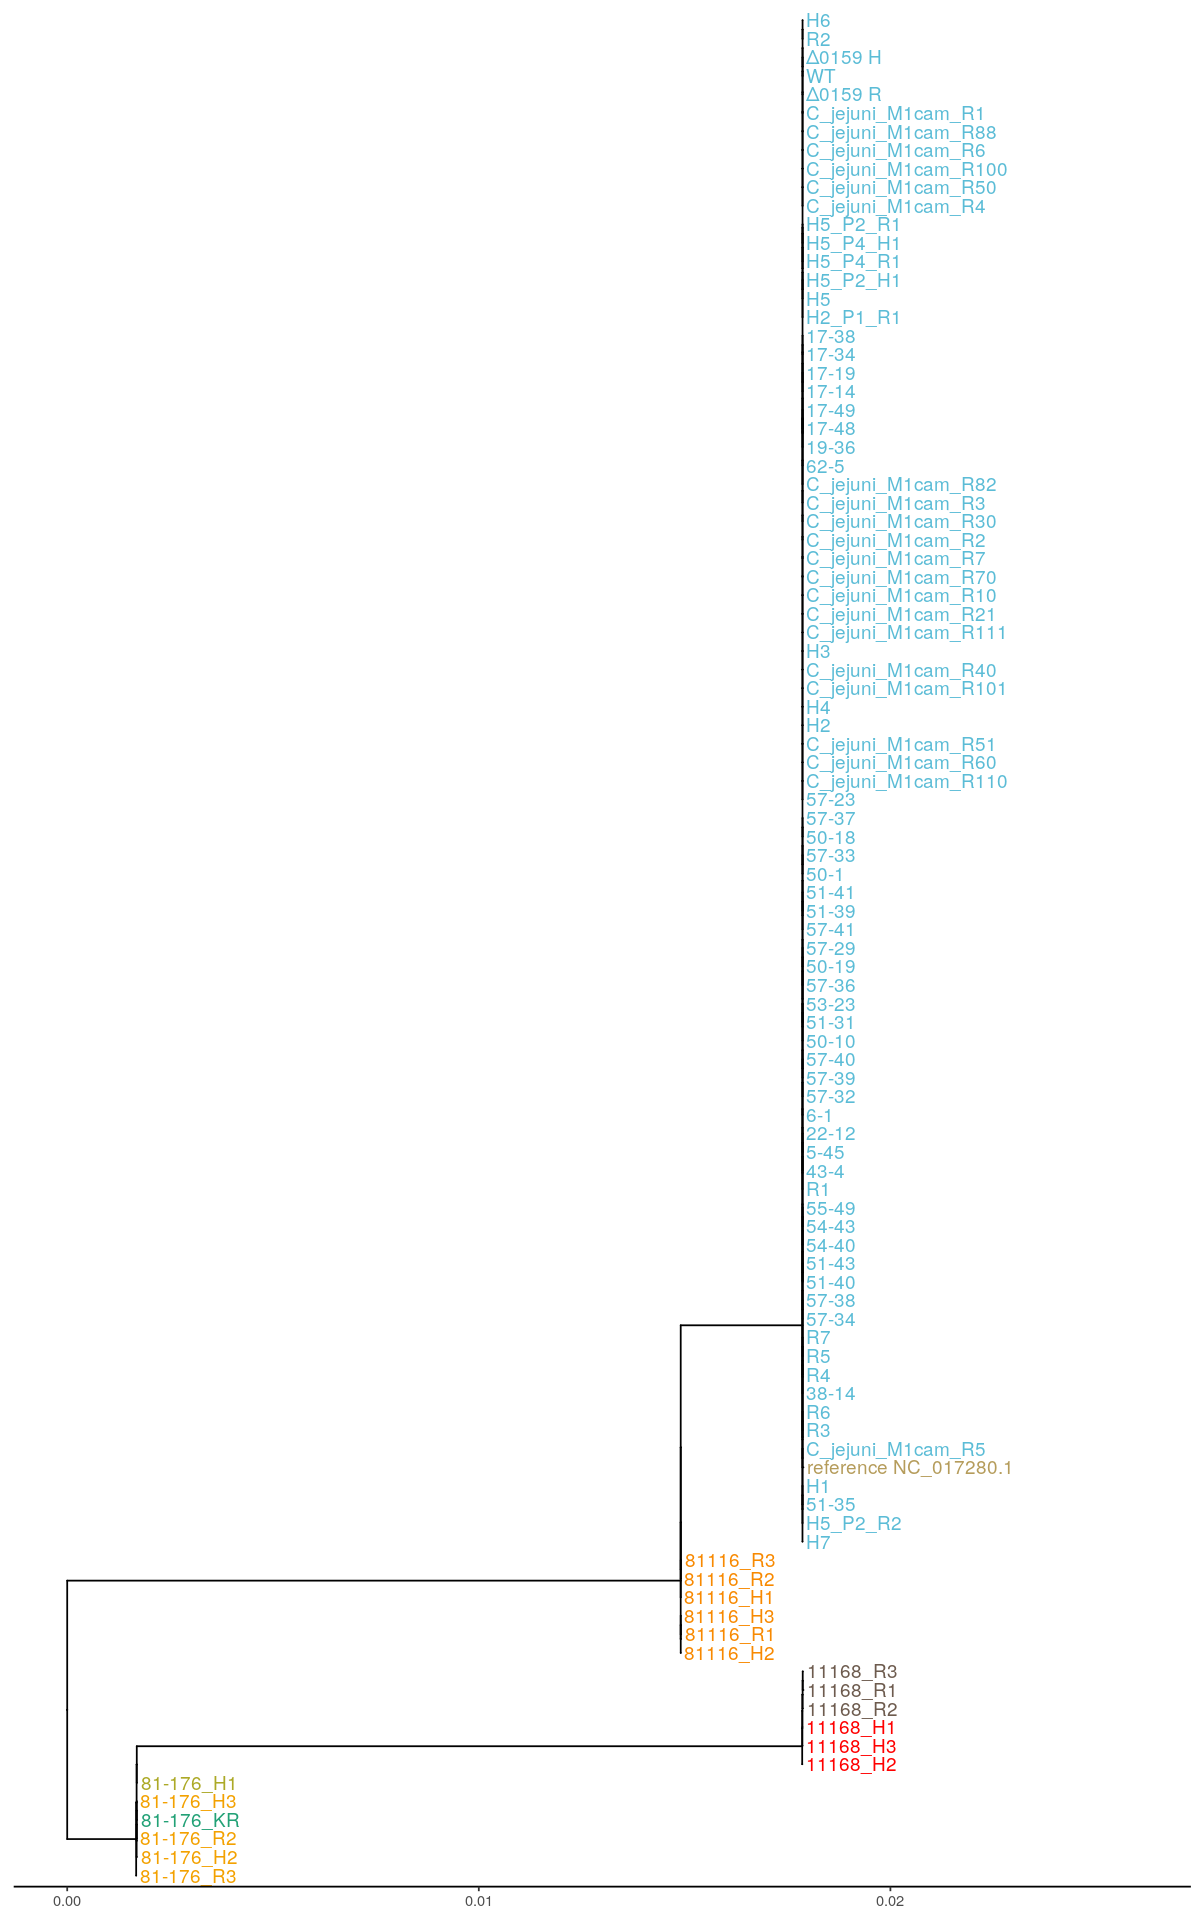

In [15]:
campy_mltree <- read.tree("campy-snippycore.full.tre")
campy_mltree <- midpoint (campy_mltree)
campy_mltree$tip.label <- gsub ("out","",campy_mltree$tip.label)
campy_mltree$tip.label <- campy_names[campy_mltree$tip.label]
options(repr.plot.width=10, repr.plot.height=16) ; par(oma=c(0,0,0,0))
p <- ggtree(campy_mltree) + geom_tiplab(aes(color=label), size=4, linetype=1, linesize=0.08, align=F) +
    ggplot2::scale_color_manual(values = campy_cluster_colors, guide="none") + xlim(0, 0.026) + 
    theme_tree2 ()

p
ggsave(plot=p,file="figures.campy_mltree.png", width=8, height=16)

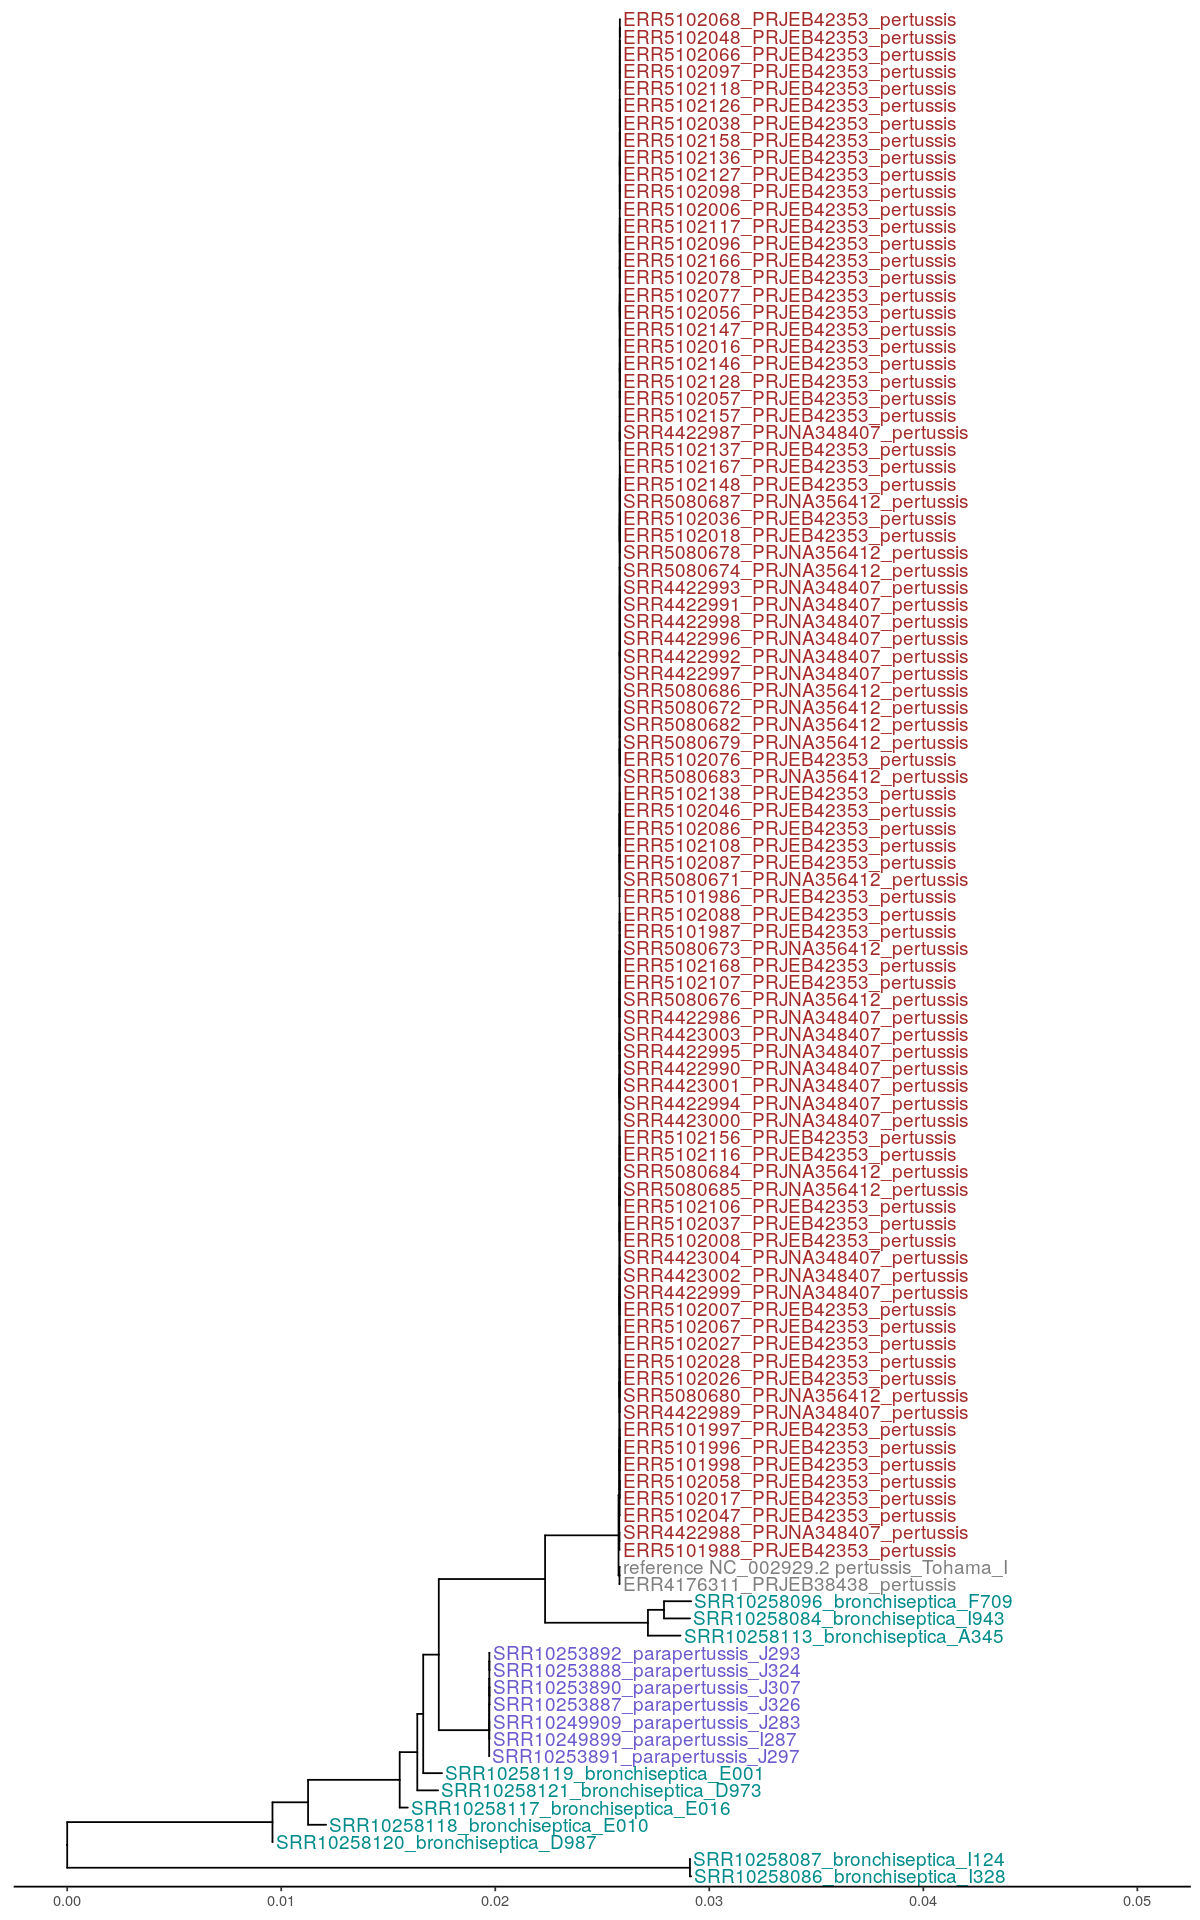

In [16]:
borde_mltree <- read.tree("borde-snippycore.full.tre")
borde_mltree <- midpoint (borde_mltree)
borde_mltree$tip.label <- replace_borde_names(borde_mltree$tip.label)
options(repr.plot.width=10, repr.plot.height=16) ; par(oma=c(0,0,0,0))
p <- ggtree(borde_mltree) + geom_tiplab(aes(color=label), size=4, linetype=1, linesize=0.08, align=F) +
    ggplot2::scale_color_manual(values = borde_cluster_colors, guide="none") + xlim(0, 0.05) + 
    theme_tree2 ()

p
ggsave(plot=p,file="figures.borde_mltree.png", width=8, height=16)

## Other manuscript figures

In [17]:
a<-read.table("campy-per_sample_average_length.tsv.xz", sep="\t", header=T, check.names = F) # check.names replaces backslash by "."
#a<-a[,-ncol(a)]  ## remove last column since some versions of tatajuba added EXTRA tab 
x<-t(as.matrix(a[,4:length(a)]))
length(a)
rownames(x)<-gsub ("_1.fastq.gz","",rownames(x))
rownames(x)<-gsub (".*/","",rownames(x))

names<-read.table("41598_2016_BFsrep38303_MOESM1_ESM.csv",header=T, sep=",",stringsAsFactors = FALSE)
xnames<-names$Isolate.name
names(xnames)<-names$ERR
xnames["reference"] <- "reference NC_017280.1"
rownames(x) <- xnames[rownames(x)] 
length(rownames(x))
calen <- x
colnames(calen) <- a$location

a<-read.table("borde_pertussis-per_sample_average_length.tsv.xz", sep="\t", header=T, check.names = F) # check.names replaces backslash by "."
x<-t(as.matrix(a[,4:length(a)]))
rownames(x)<-replace_borde_names(rownames(x))
head(rownames(x))
clst <- as.dendrogram(hclust(dist(x), method="average"))
bolen <- x
colnames(bolen) <- a$location

[1] 104

[1] 101

[1] "reference NC_002929.2 pertussis_Tohama_I"
[2] "ERR5101986_PRJEB42353_pertussis"         
[3] "ERR5101987_PRJEB42353_pertussis"         
[4] "ERR5101988_PRJEB42353_pertussis"         
[5] "ERR5101996_PRJEB42353_pertussis"         
[6] "ERR5101997_PRJEB42353_pertussis"

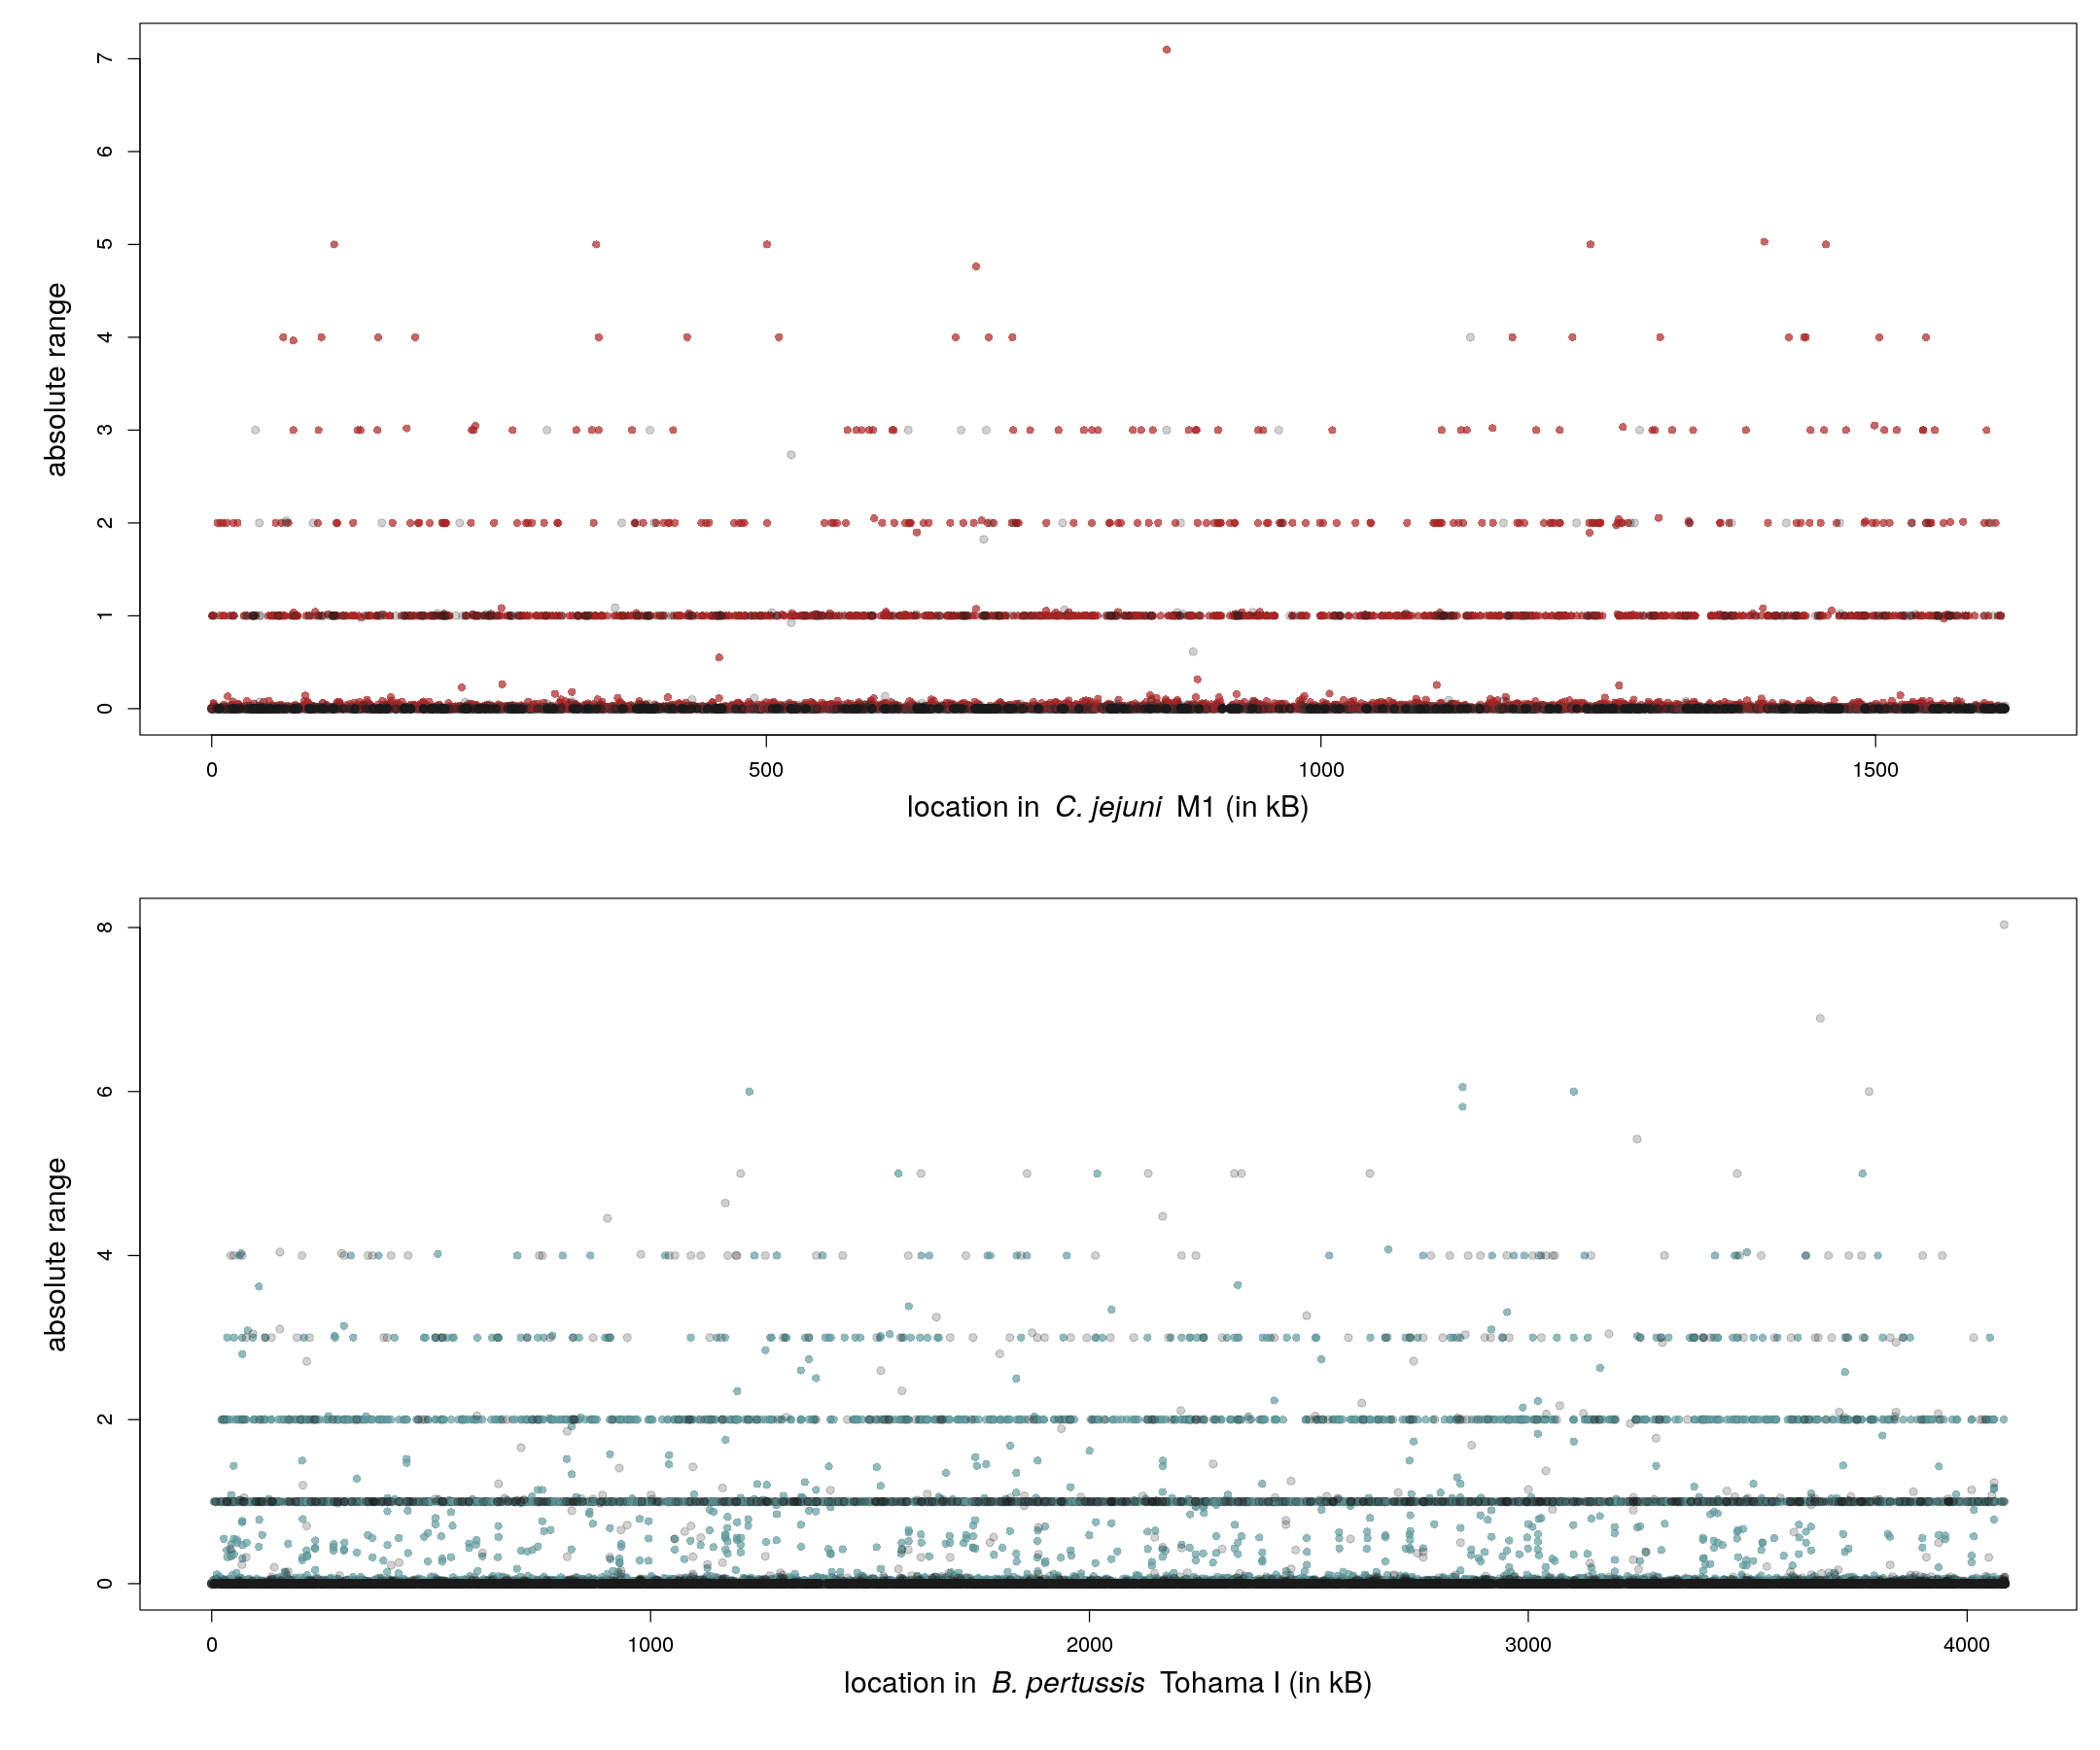

In [18]:
options(repr.plot.width=18, repr.plot.height=15)
par (cex=1.2, col.main="gray10", cex.axis=1.1, cex.lab=1.5, font=2, mar=c(6,6,1,1));
layout(matrix(1:2,ncol=1,nrow=2, byrow=F));
this_gray = rgb(0.2,0.2,0.2,0.1)
this_nonann = rgb(0.1,0.1,0.1,0.2)
this_cex = 0.9

## campy is more recent thatn borde, selected_tracts have new header name "begin_context" instead of confusion-prone "location"
x1<-read.table("campy-selected_tracts_annotated.tsv.xz", header=T)
x2<-read.table("campy-selected_tracts_unknown.tsv.xz", header=T)
x_lim = c(min(x1$begin_context,x2$begin_context),max(x1$begin_context,x2$begin_context))/1000
y_lim = c(min(x1$rd_avge_tract_length,x2$rd_avge_tract_length), max(x1$rd_avge_tract_length,x2$rd_avge_tract_length))

plot (x1$begin_context/1000, x1$rd_avge_tract_length, ylim=y_lim, xlim=x_lim, xlab = expression("location in"~italic("C. jejuni")~"M1 (in kB)"), ylab="absolute range", 
     pch=21, bg=alpha("firebrick", 0.7), col=this_gray, cex=this_cex)
points (x2$begin_context/1000, x2$rd_avge_tract_length, pch=21, bg=this_nonann, col=this_nonann, cex=this_cex)

x3<-read.table("borde_pertussis-selected_tracts_annotated.tsv.xz", header=T)
x4<-read.table("borde_pertussis-selected_tracts_unknown.tsv.xz", header=T)
x_lim = c(min(x3$location,x4$location),max(x3$location,x4$location))/1000
y_lim = c(min(x3$rd_avge_tract_length,x4$rd_avge_tract_length), max(x3$rd_avge_tract_length,x4$rd_avge_tract_length))

plot (x3$location/1000, x3$rd_avge_tract_length, ylim=y_lim, xlim=x_lim, xlab = expression("location in"~italic("B. pertussis")~"Tohama I (in kB)"), 
      ylab="absolute range", pch=21, bg=alpha("cadetblue", 0.7), col=this_gray, cex=this_cex)
points (x4$location/1000, x4$rd_avge_tract_length, pch=21, bg=this_nonann, col=this_nonann, cex=this_cex)


#### code below is "commented out" since `figures.range.svg` is too big (>60MB) 

### Zoom in into regions of interest (average HT length as feature matrices)

In [19]:
in_gene <- (as.numeric(colnames(calen)) > 1268323) & (as.numeric(colnames(calen)) < 1269717)
list_of_samples <- c("51-40", "11168_R1","H5_P2_R1", "17-19", "5-45", "38-14", "17-14", "17-34", "17-38", "17-49", "43-4", "C_jejuni_M1cam_R88", "22-12", 
                     "H5_P2_R2", "H5_P4_R1", "50-1", "H2_P1_R1", "62-5", "reference NC_017280.1", "81116_H1", "81116_R1", 
                     "81-176_KR", "81-176_R2", "C_jejuni_M1cam_R10") 
#rownames(calen)
in_sample <- as.logical(lapply(rownames(calen), function(x){x %in% list_of_samples}))
x <- calen[in_sample, in_gene]

In [20]:
article_idx <- read.csv("1471-2164-8-122-S3_pertussis.csv", header=T)$Start
is_it_close <- function (x) {
    y <- sort (abs(as.numeric(x)-article_idx))[1]
    if ( y < 50) {
        #print(paste(x,y)); 
        return (TRUE);
    }
    return (FALSE);
}

new_bolen <- bolen[,bolen["reference NC_002929.2 pertussis_Tohama_I",]>4]  ## only big HT
in_gene <- as.logical(lapply(colnames(new_bolen), is_it_close))
#rownames(new_bolen)
#in_gene <- (as.numeric(colnames(calen)) > 1268323) & (as.numeric(colnames(calen)) < 1269717)
list_of_samples <- c("reference NC_002929.2 pertussis_Tohama_I", "ERR4176311_PRJEB38438_pertussis",
                     "ERR5101986_PRJEB42353_pertussis",  "ERR5102167_PRJEB42353_pertussis","ERR5102046_PRJEB42353_pertussis",
                     "SRR4422986_PRJNA348407_pertussis", "SRR4423004_PRJNA348407_pertussis",
                     "SRR5080672_PRJNA356412_pertussis", "SRR5080683_PRJNA356412_pertussis",
                    "SRR10258084_bronchiseptica_I943", "SRR10258119_bronchiseptica_E001", "SRR10258086_bronchiseptica_I328", 
                     "SRR10253892_parapertussis_J293", "SRR10253890_parapertussis_J307") 

in_sample <- as.logical(lapply(rownames(new_bolen), function(x){x %in% list_of_samples}))
x <- new_bolen[in_sample, in_gene]
x <- x[match(list_of_samples,rownames(x)),]

In [21]:
list_of_samples <- c("51-40", "11168_R1","H5_P2_R1", "17-19", "5-45", "38-14", "17-14", "17-34", "17-38", "17-48", "43-4", "C_jejuni_M1cam_R88", "22-12", 
                     "H5_P2_R2", "H5_P4_R1", "50-1", "H2_P1_R1", "62-5", "reference NC_017280.1", "81116_H1", "81116_R1", 
                     "81-176_KR", "81-176_R2", "C_jejuni_M1cam_R10") 
in_sample <- as.logical(lapply(rownames(calen), function(x){x %in% list_of_samples}))
## these two changes are not homopolymer tracts: 1269447 1268939 
camp_idx = c(1269149,1268944,1268899,1268857,1268827,1268739,1268531,1268425,846319,846256,846075,846037,846702)
is_it_close <- function (x) {
    y <- sort (abs(camp_idx - as.numeric(x)))[1]
    if ( y < 12) {
        #print(paste(x,y)); 
        return (TRUE);
    }
    return (FALSE);
}
print (sort(camp_idx))
in_gene <- as.logical(lapply(colnames(calen), is_it_close))
x <- calen[in_sample, in_gene]

 [1]  846037  846075  846256  846319  846702 1268425 1268531 1268739 1268827
[10] 1268857 1268899 1268944 1269149


png 
  2

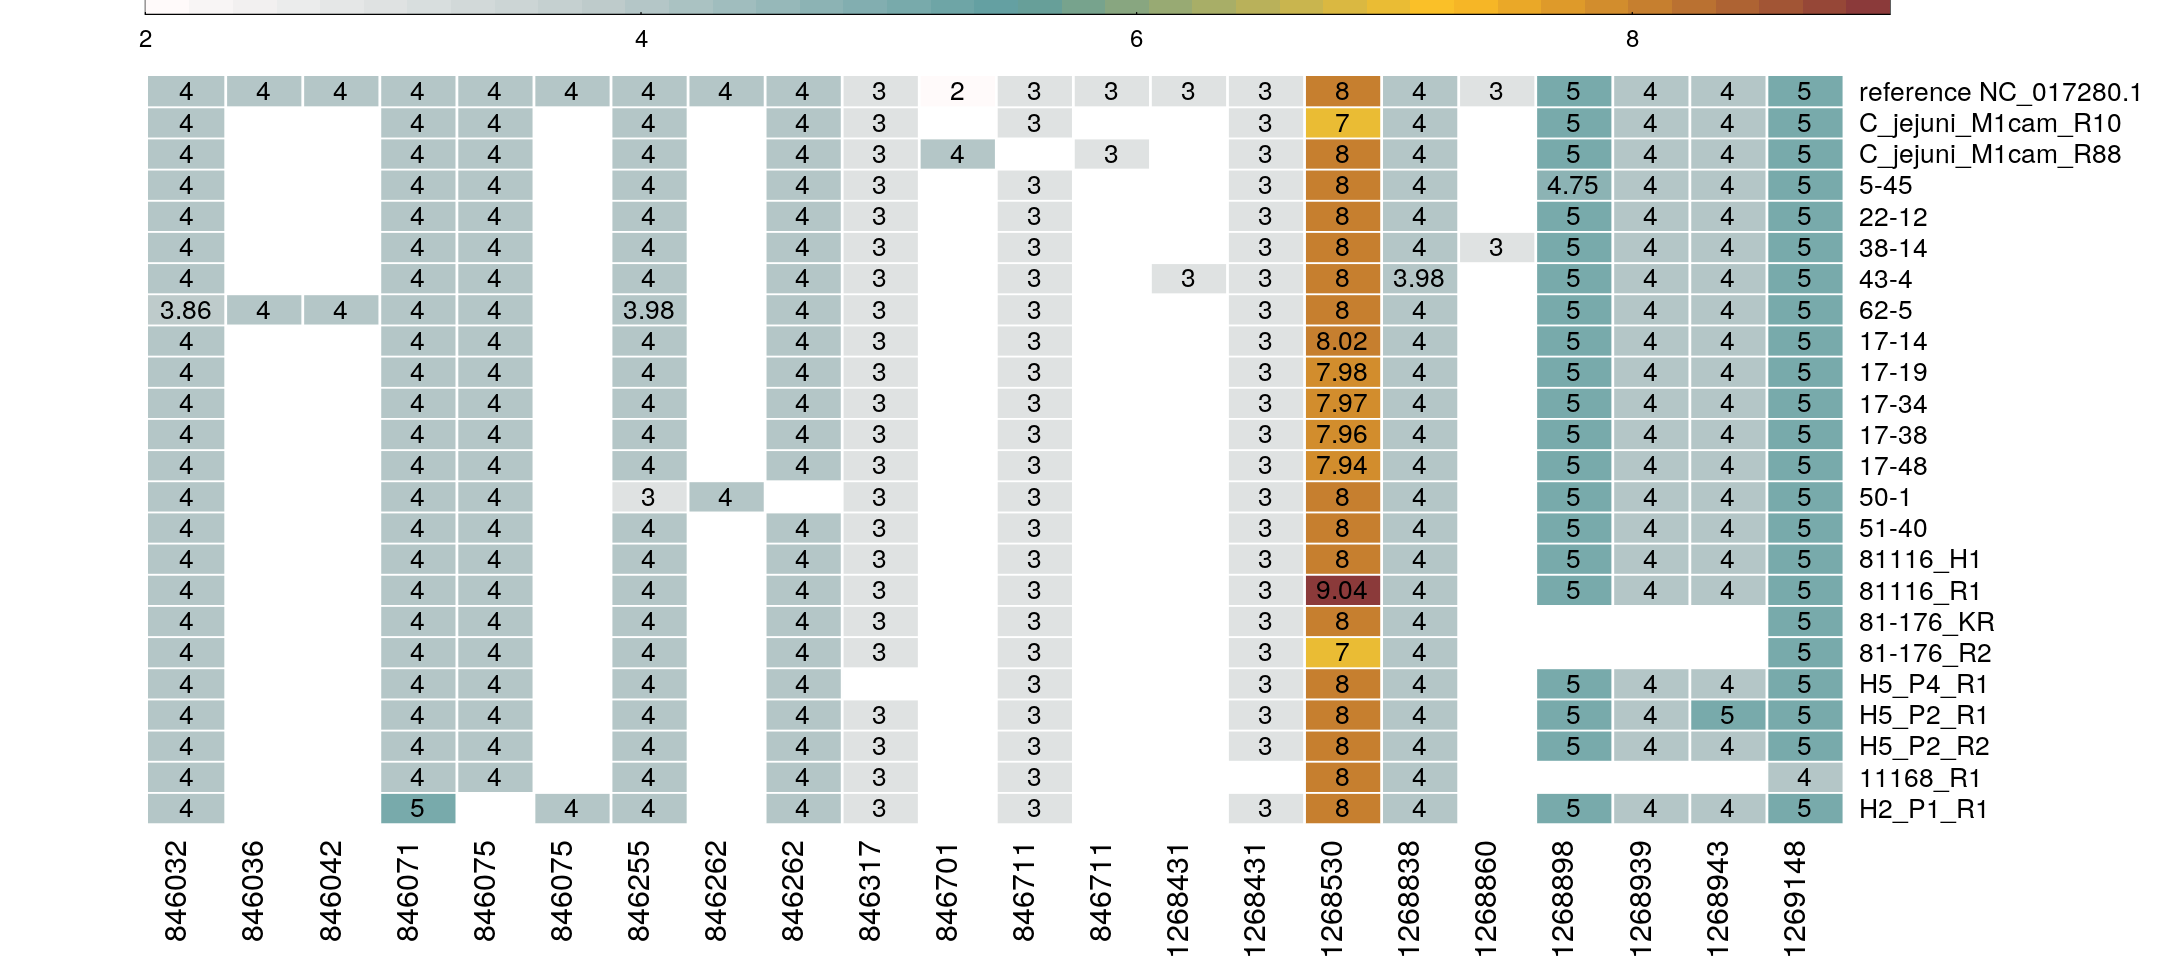

In [22]:
options(repr.plot.width=18, repr.plot.height=8)
par(oma=c(3.6,0,0,15))

#coul <- colorRampPalette(brewer.pal(9, "YlOrBr"))(12)[2:12]
coul <- colorRampPalette(c("snow", "azure3", "cadetblue", "goldenrod1", "indianred4"))(40)

x2 <- ifelse (x < 0.1, "", round(x,2))
heatmap.2 (x, scale="none", col= coul, # do not rescale (standardise) values
           cexRow=2, cexCol=2.3, # column text size
           rowsep=1:110, colsep=1:450,  sepwidth=c(0.02, 0.02),
           Colv=FALSE, Rowv = FALSE, dendrogram = "none", 
           cellnote = x2, notecex=2, notecol="black",  ## numbers inside cells
           tracecol=NA,  # remove vertical lines
           lmat = rbind( c(0,4), c(0, 3), c(2,1) ), lhei=c(1, 0.1, 12), lwid=c(1,12),  # proportions of width and height
           key=TRUE, keysize=0.2, key.ylab=NA, key.xlab=NA, symkey=FALSE, symbreaks=FALSE, key.title = NA, density.info="none",
           key.par=list(cex.axis=1.6, tcl=0.1, mar=c(3,0,0,0))
           )    # remove color histogram from top left corner

svg(filename="figures.campy_hts.svg", width=18, height=8, pointsize=12)
par(oma=c(3.6,0,0,15))
heatmap.2 (x, scale="none", col= coul, # do not rescale (standardise) values
           cexRow=2, cexCol=2.3, # column text size
           rowsep=1:110, colsep=1:450,  sepwidth=c(0.02, 0.02),
           Colv=FALSE, Rowv = FALSE, dendrogram = "none", 
           cellnote = x2, notecex=2, notecol="black",  ## numbers inside cells
           tracecol=NA,  # remove vertical lines
           lmat = rbind( c(0,4), c(0, 3), c(2,1) ), lhei=c(1, 0.1, 12), lwid=c(1,12),  # proportions of width and height
           key=TRUE, keysize=0.2, key.ylab=NA, key.xlab=NA, symkey=FALSE, symbreaks=FALSE, key.title = NA, density.info="none",
           key.par=list(cex.axis=1.6, tcl=0.1, mar=c(3,0,0,0)))
dev.off()


### fix the strandness for start location of Bordetella

[1] 50

table with HTs reported previously but which are absent from tatajuba results:

Coding.or.Intergenic HPT.number Gene   Start   Length Base Strand Stop   
11 I                    66         BP1047 1090818  7     C    -1     1090812
17 I                    35         BP0146  147886 15     C    -1      147900
22 I                    71         BP1793 1881152  2     G     1     1881153
47 I                     9         fim2   1176545 12     C    -1     1176534
48 I                     3         fim3   1647539 13     C     1     1647527
51 C                    37         fhaB 1 1969858 10     G     1     1969867
56 C                    82         bapC 2 2907994 14     C     1     2908007
58 I                    46         BP3474 3688166 13     C    -1     3688154
   Notes                       Distance..nt..from.start.codon..intergenic.only.
11 assoc with IS               132                                             
17                             21                                              
22                             169a                                            
47                             49                                              
48                             63                                              
51                                                                             
56 annotated as phase variable                                                 
58                             95                                              
   Probability.that.intergenic.HPT.overlaps.promoter
11 M                                                
17 H                                                
22 L                                                
47 K                                                
48 K                                                
51                                                  
56                                                  
58 M

png 
  2

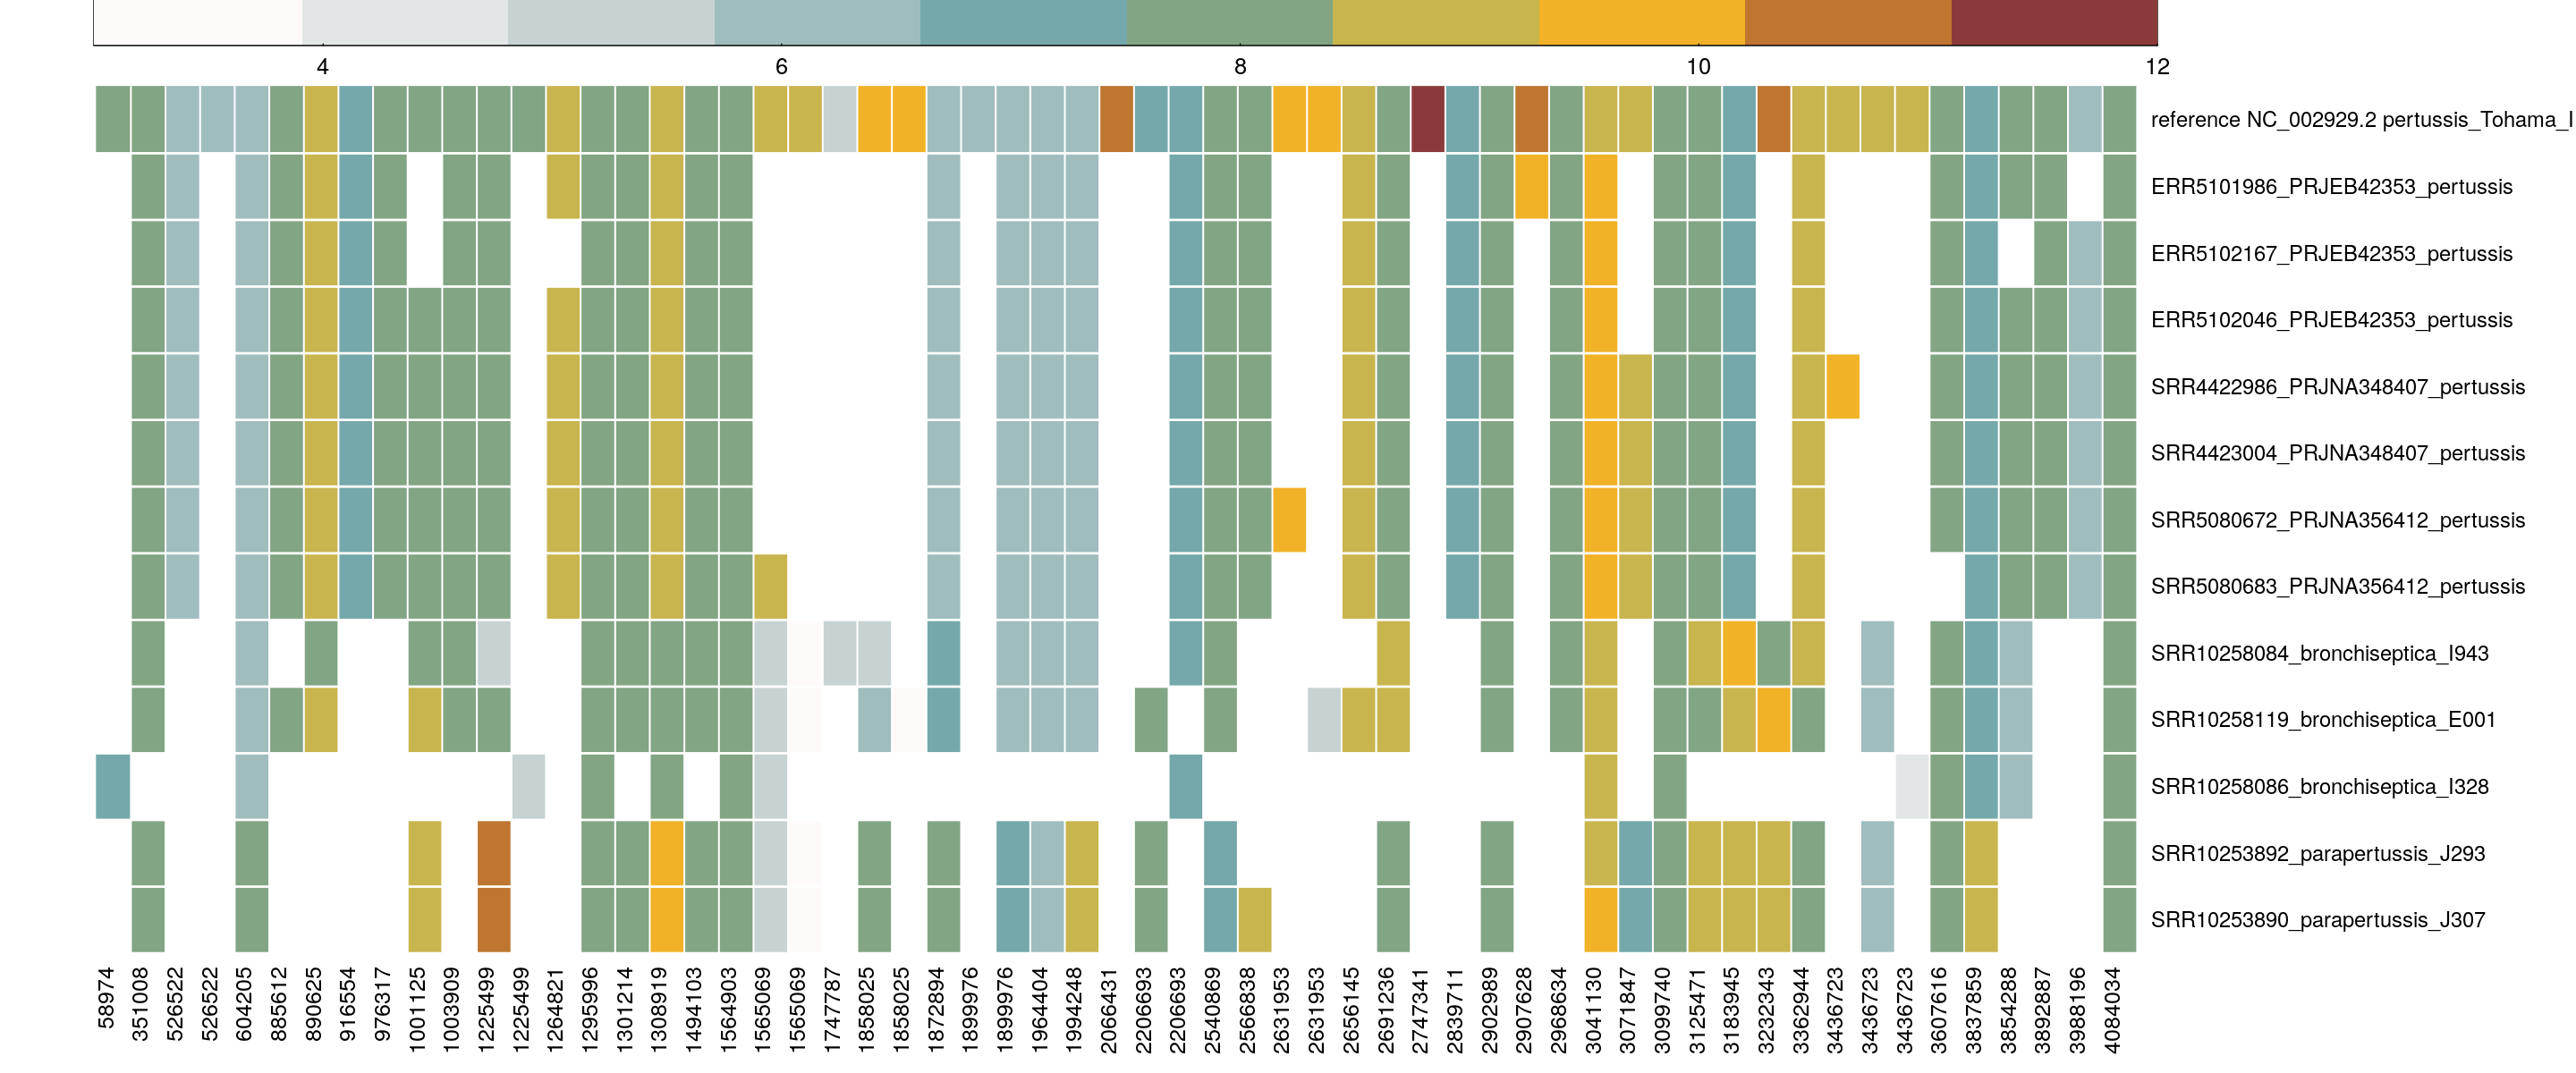

In [23]:
article_csv <- read.csv("1471-2164-8-122-S3_pertussis.csv", header=T)
article_idx <- pmin(article_csv$Start, article_csv$Stop)

is_it_close <- function (x) {
    y <- sort (abs(as.numeric(x)-article_idx))[1]
    if ( y < 5) {
#        print(paste(x,y)); ## if you want to see all nearby locations
        return (TRUE);
    }
    return (FALSE);
}

new_bolen <- bolen[,bolen["reference NC_002929.2 pertussis_Tohama_I",]>4]  ## only big HT
in_gene <- as.logical(lapply(colnames(new_bolen), is_it_close))

#rownames(new_bolen)
#in_gene <- (as.numeric(colnames(calen)) > 1268323) & (as.numeric(colnames(calen)) < 1269717)
list_of_samples <- c("reference NC_002929.2 pertussis_Tohama_I", # "ERR4176311_PRJEB38438_pertussis",
                     "ERR5101986_PRJEB42353_pertussis",  "ERR5102167_PRJEB42353_pertussis","ERR5102046_PRJEB42353_pertussis",
                     "SRR4422986_PRJNA348407_pertussis", "SRR4423004_PRJNA348407_pertussis",
                     "SRR5080672_PRJNA356412_pertussis", "SRR5080683_PRJNA356412_pertussis",
                    "SRR10258084_bronchiseptica_I943", "SRR10258119_bronchiseptica_E001", "SRR10258086_bronchiseptica_I328", 
                     "SRR10253892_parapertussis_J293", "SRR10253890_parapertussis_J307") 

in_sample <- as.logical(lapply(rownames(new_bolen), function(x){x %in% list_of_samples}))
x <- new_bolen[in_sample, in_gene]
x <- x[match(list_of_samples,rownames(x)),]
length(unique(colnames(x)))

### find HTs reported in original bordetella article but which we could not find 
### (most of them are found if we remove strand bias correction):
cat("table with HTs reported previously but which are absent from tatajuba results:")
miss_ht <- setdiff(article_idx, as.integer(unique(colnames(x)))+1)
article_csv[article_idx %in% miss_ht,] 


options(repr.plot.width=24, repr.plot.height=10)
par(oma=c(3.5,0,0,26))
coul <- colorRampPalette(c("snow", "azure3", "cadetblue", "goldenrod1", "indianred4"))(10)

x2 <- ifelse (x < 0.1, "", round(x,1))
heatmap.2 (x, scale="none", col= coul, # do not rescale (standardise) values
           cexRow=1.8, cexCol=1.9, # column text size
           rowsep=1:110, colsep=1:450,  sepwidth=c(0.02, 0.02),
           Colv=FALSE, Rowv = FALSE, dendrogram = "none", 
           #cellnote = x2, notecex=0.9, notecol="black",  ## numbers inside cells
           tracecol=NA,  # remove vertical lines
           #key=FALSE, lhei=c(1, 24), lwid=c(1,24),  # proportions of width and height
           
           lmat = rbind( c(0,4), c(0, 3), c(2,1) ), lhei=c(1, 0.1, 12), lwid=c(1,22),  # proportions of width and height
           key=TRUE, keysize=0.2, key.ylab=NA, key.xlab=NA, symkey=FALSE, symbreaks=FALSE, key.title = NA, density.info="none",
           key.par=list(cex.axis=1.7, tcl=0.1, mar=c(2,0,0,0))
           )    # remove color histogram from top left corner

svg(filename="figures.borde_hts.svg", width=24, height=10, pointsize=12)
par(oma=c(3.5,0,0,26))
heatmap.2 (x, scale="none", col= coul, # do not rescale (standardise) values
           cexRow=1.8, cexCol=1.9, # column text size
           rowsep=1:110, colsep=1:450,  sepwidth=c(0.02, 0.02),
           Colv=FALSE, Rowv = FALSE, dendrogram = "none", 
           #cellnote = x2, notecex=0.9, notecol="black",  ## numbers inside cells
           tracecol=NA,  # remove vertical lines
           #key=FALSE, lhei=c(1, 24), lwid=c(1,24),  # proportions of width and height
           
           lmat = rbind( c(0,4), c(0, 3), c(2,1) ), lhei=c(1, 0.1, 12), lwid=c(1,22),  # proportions of width and height
           key=TRUE, keysize=0.2, key.ylab=NA, key.xlab=NA, symkey=FALSE, symbreaks=FALSE, key.title = NA, density.info="none",
           key.par=list(cex.axis=1.7, tcl=0.1, mar=c(2,0,0,0))
           )    # remove color histogram from top left corner
dev.off()